# Fine-Tuning no ICDAR 2019 - Approach 4

## Abordagem usando o checkpoint do modelo treinado no *approach 2 (onde é congelado o efficient-net e T5)*  usando o checkpoint agora com um lr bem pequeno

## Enunciado

O objetivo deste exercício é treinar uma rede similar à da aula 7 (CNN como codificadora + decodificador do transformer) mas tendo como entrada imagens de recibos reais. A saída esperada é o nome da compania e seu endereço. 

Iremos usar o [dataset SROIE da competição ICDAR 2019.](https://rrc.cvc.uab.es/?ch=13&com=introduction)

Métricas: usar o código abaixo para calcular o exact match da resposta toda e F1 de palavras.

In [1]:
version = "finetuning_augm_extract_app4_adafactor_seqred_test2" #@param {type: "string"}
lr =  1e-5#@param {type: "number"}
bs =    12#@param {type: "integer"} 
accum =    6#@param {type: "integer"} 
seq_len =  64#@param {type: "integer"}
patience =  10#@param {type: "integer"}
max_epochs =  500#@param {type: "integer"}
dropout_rate = 0.3#@param {type: "number"}
drop_connect_rate = 0.5#@param {type: "number"}
debug = False #@param {type: "boolean"}


# Define hyperparameters
hparams = {"version": version,
           "lr": lr,
           "bs": bs,
           "accum": accum,
           "seq_len": seq_len,
           "patience": patience,
           "max_epochs": max_epochs,
           "dropout_rate": dropout_rate,
           "drop_connect_rate": drop_connect_rate,
           "debug": debug, 
           "enet": "efficientnet-b0",
           "t5": "t5-small"}
hparams             

{'accum': 6,
 'bs': 12,
 'debug': False,
 'drop_connect_rate': 0.5,
 'dropout_rate': 0.3,
 'enet': 'efficientnet-b0',
 'lr': 1e-05,
 'max_epochs': 500,
 'patience': 10,
 'seq_len': 64,
 't5': 't5-small',
 'version': 'finetuning_augm_extract_app4_adafactor_seqred_test2'}

In [2]:
import nvidia_smi
from google.colab import drive

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


## Download do dataset

In [4]:
!gsutil -m cp -n gs://neuralresearcher_data/unicamp/ia376j_2020s2/aula8/dataset_sroie_icdar_2019.zip .
!unzip dataset_sroie_icdar_2019.zip

Copying gs://neuralresearcher_data/unicamp/ia376j_2020s2/aula8/dataset_sroie_icdar_2019.zip...
- [1/1 files][268.8 MiB/268.8 MiB] 100% Done                                    
Operation completed over 1 objects/268.8 MiB.                                    
Archive:  dataset_sroie_icdar_2019.zip
   creating: test/
  inflating: test/X51008099073.txt   
  inflating: test/X51008099089.txt   
  inflating: test/X51008099081.jpg   
  inflating: test/X51008114260.jpg   
  inflating: test/X51008099054.jpg   
  inflating: test/X51008099073.jpg   
  inflating: test/X51008114260.txt   
  inflating: test/X51008114217.txt   
  inflating: test/X51008099102.txt   
  inflating: test/X51008099102.jpg   
  inflating: test/X51008114216.jpg   
  inflating: test/X51008114262.txt   
  inflating: test/X51008123447.jpg   
  inflating: test/X51008099083.jpg   
  inflating: test/X51008114266.txt   
  inflating: test/X51008122920.jpg   
  inflating: test/X51008114283.txt   
  inflating: test/X51008114321.jpg   


O dataset contém 626 imagens e suas respectiva anotações (respostas), sendo 200 imagens separadas para teste. Cada imagem tem um arquivo txt correspondente que contém as respostas em formato json.

In [5]:
!pip install neptune-client --quiet 

     |████████████████████████████████| 102kB 6.4MB/s 
     |████████████████████████████████| 829kB 15.8MB/s 
     |████████████████████████████████| 61kB 8.4MB/s 
     |████████████████████████████████| 204kB 34.8MB/s 
     |████████████████████████████████| 163kB 54.3MB/s 
     |████████████████████████████████| 71kB 8.6MB/s 
     |████████████████████████████████| 133kB 49.8MB/s 
     |████████████████████████████████| 71kB 9.5MB/s 


In [6]:
!pip install fairseq --quiet 

     |████████████████████████████████| 1.7MB 13.2MB/s 
     |████████████████████████████████| 71kB 10.2MB/s 
     |████████████████████████████████| 133kB 55.0MB/s 
     |████████████████████████████████| 112kB 54.3MB/s 
     |████████████████████████████████| 276kB 50.2MB/s 


In [7]:
!pip install sacrebleu pytorch-lightning transformers==3.5.1 efficientnet-pytorch --quiet     

     |████████████████████████████████| 686kB 13.4MB/s 
     |████████████████████████████████| 1.3MB 32.5MB/s 
     |████████████████████████████████| 102kB 12.5MB/s 
     |████████████████████████████████| 2.9MB 29.7MB/s 
     |████████████████████████████████| 1.1MB 55.9MB/s 
     |████████████████████████████████| 890kB 49.9MB/s 
     |████████████████████████████████| 1.3MB 44.0MB/s 
     |████████████████████████████████| 143kB 56.4MB/s 
     |████████████████████████████████| 296kB 53.2MB/s 


In [8]:
!mkdir "output"

In [9]:
import os
import numpy as np
import shutil
import random
import glob

# # Creating Train / Val / Test folders (One time use)
root_dir = 'output'
mode = 'train'
val_ratio = 0.25
src_dir = 'train'

os.makedirs(root_dir +'/train')
os.makedirs(root_dir +'/val')

allFileNames = glob.glob(f"{mode}/*.txt")
np.random.shuffle(allFileNames)
train_FileNames, val_FileNames = np.split(np.array(allFileNames),
                                                [int(len(allFileNames)* (1 - val_ratio))])


train_FileNames = [name for name in train_FileNames.tolist()]
val_FileNames = [name for name in val_FileNames.tolist()]

print('Total images: ', len(allFileNames))
print('Training: ', len(train_FileNames))
print('Validation: ', len(val_FileNames))

# Copy-pasting images
for name in train_FileNames:
    shutil.copy(name, root_dir +'/train')
    shutil.copy(name[:-4]+'.jpg', root_dir +'/train')

for name in val_FileNames:
    shutil.copy(name, root_dir +'/val')
    shutil.copy(name[:-4]+'.jpg', root_dir +'/val')


Total images:  426
Training:  319
Validation:  107


In [10]:
import json
import matplotlib.pyplot as plt
import pytorch_lightning as pl
from efficientnet_pytorch import EfficientNet
import os
import json
import random
import gc
from fairseq.optim import adafactor
import cv2
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Lambda, ToTensor, Compose
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from transformers import T5Tokenizer, T5ForConditionalGeneration
import sacrebleu
from pytorch_lightning.loggers.neptune import NeptuneLogger

In [11]:
print(f"Pytorch Lightning Version: {pl.__version__}")
nvidia_smi.nvmlInit()
handle = nvidia_smi.nvmlDeviceGetHandleByIndex(0)
print(f"Device name: {nvidia_smi.nvmlDeviceGetName(handle)}")

def gpu_usage():
    global handle
    return str(nvidia_smi.nvmlDeviceGetUtilizationRates(handle).gpu) + '%'

Pytorch Lightning Version: 1.1.3
Device name: b'Tesla V100-SXM2-16GB'


In [12]:
data_json = json.load(open("train/X00016469612.txt"))
print(data_json)

print(data_json["company"])
print(data_json["address"])

{'company': 'BOOK TA .K (TAMAN DAYA) SDN BHD', 'date': '25/12/2018', 'address': 'NO.53 55,57 & 59, JALAN SAGU 18, TAMAN DAYA, 81100 JOHOR BAHRU, JOHOR.', 'total': '9.00'}
BOOK TA .K (TAMAN DAYA) SDN BHD
NO.53 55,57 & 59, JALAN SAGU 18, TAMAN DAYA, 81100 JOHOR BAHRU, JOHOR.


In [13]:
TOKENIZER = T5Tokenizer.from_pretrained(hparams['t5'])

extra_tokens = ['[NL]'] # Add token de 'nova linha' para multiline
added_tokens = []
for tok in extra_tokens:
  enc = TOKENIZER.encode(tok)
  if 2 in enc:
      added_tokens.append(tok)
      TOKENIZER.add_tokens(tok)

# Remover espaço em branco (apresentado pelo diedre)

Area Ratio: 0.29614160348092544
Width Height Ratio: 0.31994362226920364


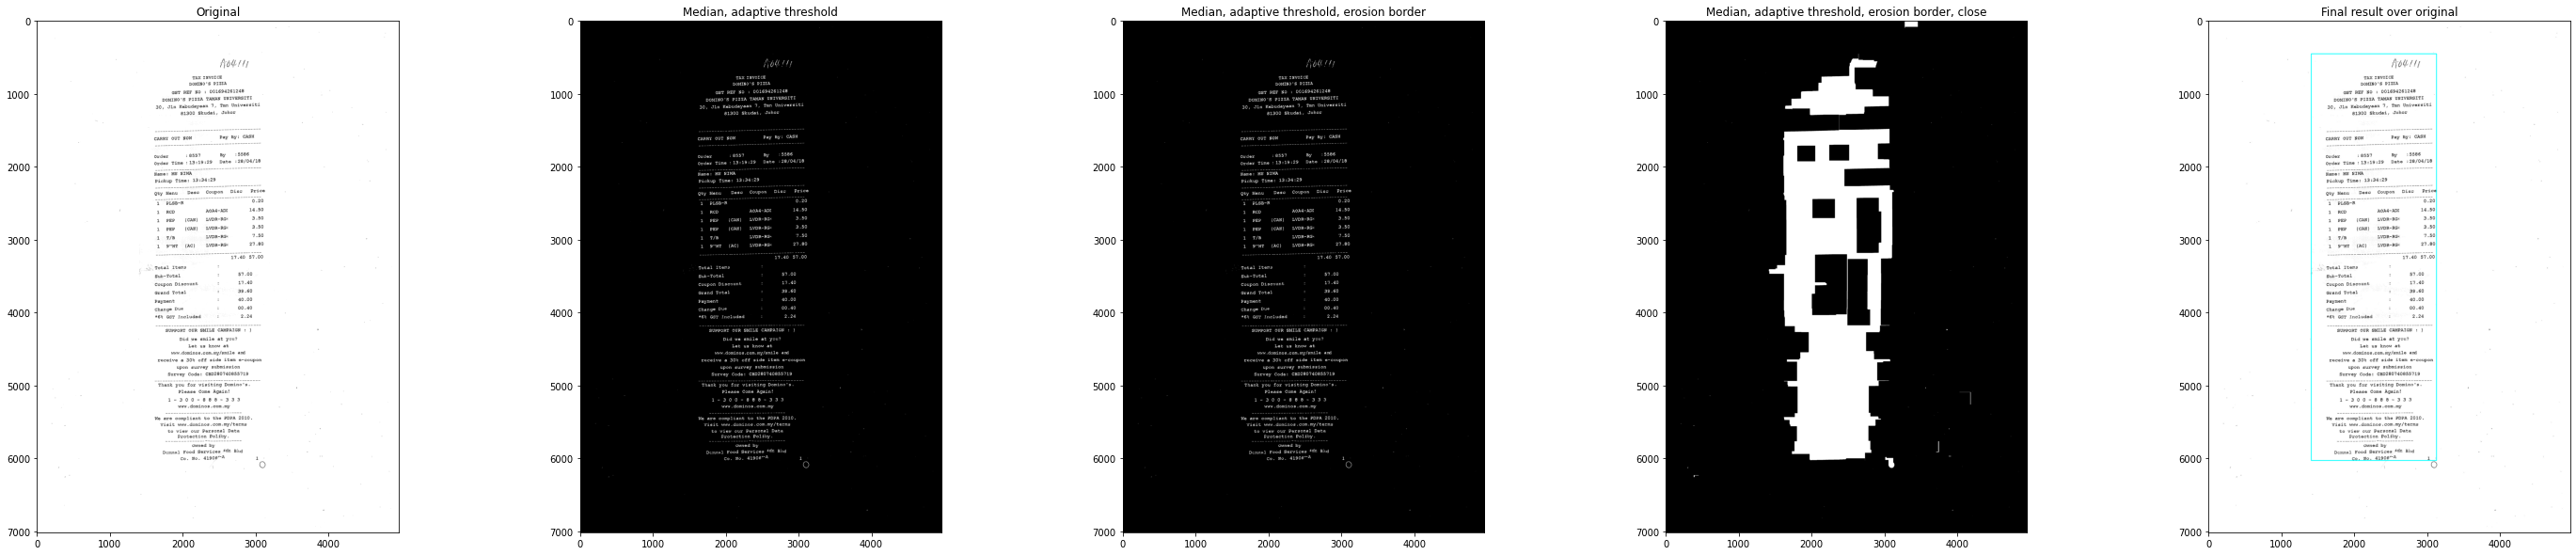

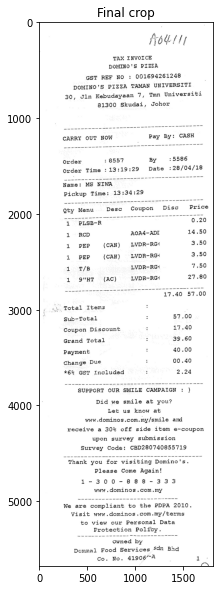

In [14]:
def implot(im, title, subplot=None, figsize=(10, 10)):
    '''
    Plot an image with given title using subplot or figsize.
    For debug purposes.
    '''
    if subplot is None:
        plt.figure(figsize=figsize)
    else:
        plt.subplot(*subplot)
    plt.title(title)
    plt.imshow(im, cmap="gray")

def extract_recibo(image, debug=False, i=0, border=50):
    '''
    Try to extract only recibo from scan with white borders.
    Uses adaptiveThreshold, morphology closing, medianblur, contour detection and 
    minimum bounding rectangle, from the opencv library.

    Visualized results in all training images, seems to work mostly fine. 
    Didn't check performance on test images.
    '''
    # Have a gray and rgb image.
    if len(image.shape) == 2:
        gray = image.copy()
        rgb = cv2.cvtColor(gray, cv2.COLOR_GRAY2RGB)
    else:
        rgb = image.copy()
        gray = cv2.cvtColor(rgb, cv2.COLOR_RGB2GRAY)
    
    # Adaptive threshold and median blur to remove small noises and have a binary image.
    t_image = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2).astype(np.int32)
    max_v = t_image.max()
    t_image = ((t_image*-1) + max_v).astype(np.uint8)
    t_image = cv2.medianBlur(t_image, 5)
    
    # Calculate border with morphology, to avoid black scan border artifacts.
    b_image = t_image - cv2.erode(t_image, np.ones((11, 11),np.uint8))  # border image

    # Close border image with a big kernel
    c_image = cv2.morphologyEx(b_image, cv2.MORPH_CLOSE, np.ones((200, 200),np.uint8))  # close borders
    
    # Find i contour of closed image
    contours, _ = cv2.findContours(c_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contour = sorted(contours, key=cv2.contourArea, reverse=True)[i]

    # Get minimum bounding rect of contour
    rect = cv2.boundingRect(contour)
    
    # Debug drawings and plots to visualize processing
    if debug:
        display = rgb.copy()
        cv2.rectangle(display, (int(rect[0]), int(rect[1])), (int(rect[0]+rect[2]), int(rect[1]+rect[3])), (0, 255, 255), 10)
        
        # Display intermediate results
        plt.figure(figsize=(50, 10))
        implot(gray, "Original", (1, 5, 1))
        implot(t_image, "Median, adaptive threshold", (1, 5, 2))
        implot(b_image, "Median, adaptive threshold, erosion border", (1, 5, 3))
        implot(c_image, "Median, adaptive threshold, erosion border, close", (1, 5, 4))
        implot(display, "Final result over original", (1, 5, 5))

    # Add border space
    x, y, w, h = rect
    x -= border
    y -= border
    w += border*2
    h += border*2
    
    # Define topleft and bottom right, check for out of bounds
    tl = [y, x]
    br = [y + h, x + w]
    if tl[0] < 0: tl[0] = 0
    if tl[1] < 0: tl[1] = 0
    if br[0] >= gray.shape[0]: br[0] = gray.shape[0] - 1
    if br[1] >= gray.shape[1]: br[1] = gray.shape[1] - 1
    
    # Check ratios for incorrect boxes
    area_ratio = h*w/(gray.shape[0]*gray.shape[1])
    w_h_ratio = min(w, h)/max(w, h)
    
    if debug: print(f"Area Ratio: {area_ratio}\nWidth Height Ratio: {w_h_ratio}")
    
    # Check edge cases, last resort return original image.
    if w_h_ratio < 0.2:  # If h is very different from w, recursively take next largest contour
        return extract_recibo(image, debug=debug, i=i+1)
    elif area_ratio < 0.03:  # If crop is too excessive (probably took a very small part), return original image.
        
        return rgb
    else:
        # Return cropped RGB image.
        # print(tl[1])
        # print(br[1])
        if (int(br[0]) > 1.5*tl[0]):
          return rgb[tl[0]:int(br[0]), tl[1]:br[1]]
        else:  
          return rgb[tl[0]:int(br[0]), tl[1]:br[1]]

plt.show()
train_sample = cv2.imread('train/X51006414712.jpg')
implot(extract_recibo(train_sample, debug=True), title="Final crop")
plt.show()


In [15]:
# MODES = ["train", "test"]
MODES = ["output/train", "output/val", "test"]

class OCR_DATA(Dataset):
    '''
    Abstração do MSCOCO com 5 captions por imagem. 
    '''
    def __init__(self, mode, seq_len, TOKENIZER, N_augment=1, width=300, height=400, image_transform=Compose([transforms.ToTensor(), Lambda(lambda img: img * 2.0 - 1.0)])):
      '''
      mode: um de "train", test".
      seq_len: tamanho máximo de sequência. 64 padrão para alinhar com feature 8x8 da efficientnet.
      transform: transformadas para serem aplicadas somente na imagem.
      '''
      assert mode in MODES
      self.mode = mode
      self.seq_len = seq_len
      self.N_augment = N_augment

      self.image_transform = image_transform
      self.TOKENIZER = TOKENIZER

      self.reshape_trans = transforms.Compose([transforms.ToPILImage(), transforms.Resize((height, width))])  
      
      txt_files = glob.glob(f"{mode}/*.txt")
      self.targets = list()
      self.images = list()
      for txt_file in txt_files:
        self.images.append(txt_file[:-4]+'.jpg')
        with open(txt_file, 'r') as target_file:
          self.targets.append(json.load(target_file))

      if (self.mode == "output/train" and self.N_augment>1):
        new_images = list()
        new_targets = list()
        for i in range(len(self.images)):
            new_images.extend(self.N_augment*[self.images[i]])
            new_targets.extend(self.N_augment*[self.targets[i]])
        self.images = new_images
        self.targets = new_targets   

      self.len = len(self.targets)  


    def __len__(self):
      return self.len

    def __getitem__(self, i):
        '''
        Imagens são extraídas do H5PY, convertidas para o formato [H, W, C], float32.
        Transformadas padrão são normalização para efficientnet com advprop e totensor.
        Frase original também é retornada para cálculo do bleu.
        '''
        
        caption = self.targets[i]

        caption_company = caption["company"]
        
        cap_key = caption.get("address")
        if cap_key:
          caption_address = caption["address"]
        else:
          caption_address = " "
        
        caption = caption_company + " [NL] " + caption_address


        target = self.TOKENIZER.encode(caption,
                                        padding='max_length',
                                        truncation=True,
                                        max_length=self.seq_len,
                                        return_tensors='pt')[0]                          

        im_bgr = cv2.imread(self.images[i])
        im_rgb = cv2.cvtColor(im_bgr, cv2.COLOR_BGR2RGB)

        im_rgb = extract_recibo(im_rgb, debug=False)
        image = self.reshape_trans(im_rgb)
        
        if self.image_transform is not None:
          image = self.image_transform(image).detach().float()

        return image, caption, target

    def get_dataloader(self, batch_size, shuffle, num_workers=4):
        return DataLoader(self, batch_size=batch_size, shuffle=shuffle, pin_memory=True, num_workers=num_workers)

In [16]:
N_augmentation = 10

train_transforms = Compose(
    [transforms.ColorJitter(0.15,0.1,0.2,0.1),
     transforms.RandomRotation(10),
     transforms.ToTensor(),
     Lambda(lambda img: 2.0*(img - 1.0))])

test_transforms = Compose(
    [transforms.ToTensor(),
     Lambda(lambda img: 2.0*(img - 1.0))])

datasets = {"output/train": OCR_DATA("output/train", seq_len=hparams['seq_len'], TOKENIZER=TOKENIZER, N_augment=N_augmentation, image_transform=train_transforms),
            "output/val": OCR_DATA("output/val", seq_len=hparams['seq_len'], TOKENIZER=TOKENIZER, image_transform=test_transforms),
            "test": OCR_DATA("test", seq_len=hparams['seq_len'], TOKENIZER=TOKENIZER, image_transform=test_transforms)}

## Dados sobre uma amostra do dataset

max image tensor(0.)
min image tensor(-2.)
Image shape: torch.Size([3, 400, 300])
Image .transpose(1, 2, 0) shape: (400, 300, 3)
company: ABC HO TRADING [NL] NO.2&4, JALAN HARMONI 3/2, TAMAN DESA HARMONI. 81100 JOHOR BAHRU JOHOR
target: tensor([14213,     3,  6299,   332, 21577,  2365,   784, 18207,   908,  5693,
            5,   357,   184,  8525,     3, 13853, 12303,     3, 25430, 20399,
          196,   220, 13311,     6,     3,  3221,  9312,  3396,  4507,     3,
        25430, 20399,   196,     5,     3,  4959,  2915,   446,  9195,  2990,
          272, 14084,  8503,   446,  9195,  2990,     1,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0])


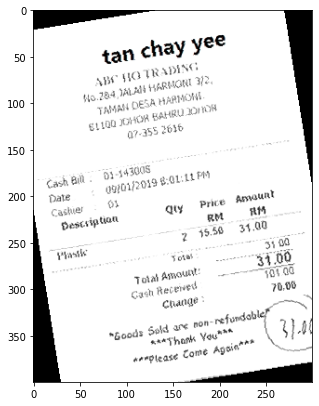

In [17]:
image = datasets["output/train"][2][0]
print('max image', image.max())
print('min image', image.min())
print('Image shape:', image.shape)
print('Image .transpose(1, 2, 0) shape:', image.cpu().numpy().transpose(1, 2, 0).shape)


plt.figure(figsize=(5, 10))
plt.imshow(((image.cpu().numpy().transpose(1, 2, 0)/2+1)))

company = datasets["output/train"][2][1]
print('company:', company)

target = datasets["output/train"][2][2]
print('target:', target)

## Representação das mesma imagem que foram augmentadas 5x

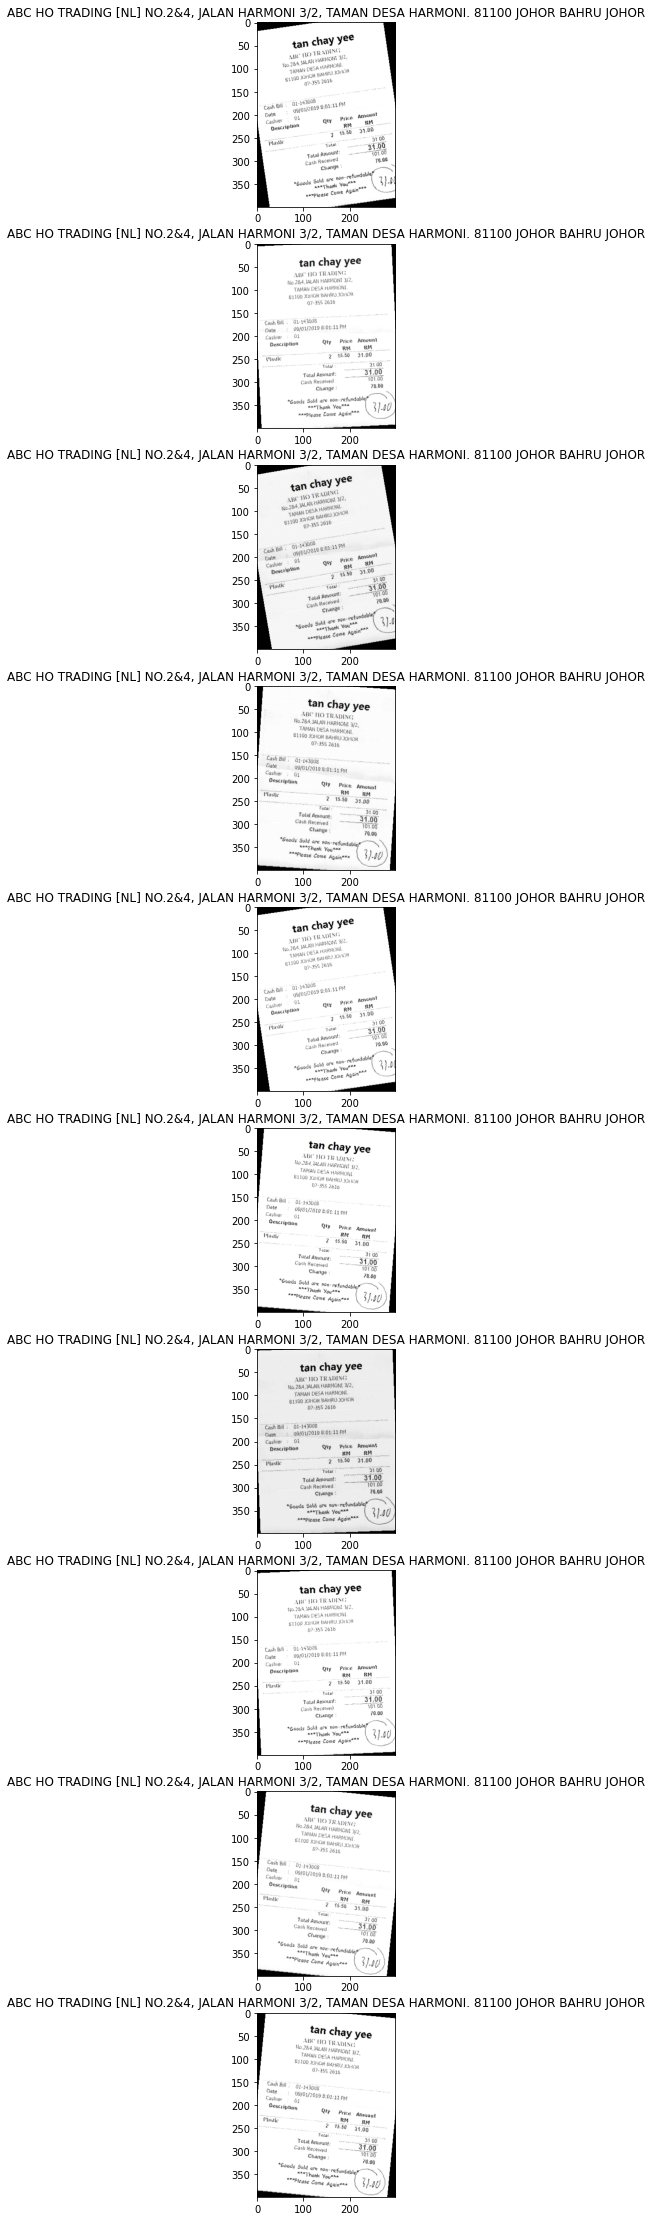

In [18]:
if N_augmentation>1:
  fig, axs = plt.subplots(N_augmentation, 1, figsize=(10, 40))
  for i in range(N_augmentation):
    image = datasets["output/train"][i][0]
    company = datasets["output/train"][i][1]
    axs[i].set_title(company)
    axs[i].imshow(((image.cpu().numpy().transpose(1, 2, 0)/2+1)))
  plt.show()

In [19]:
dataset_lens = {mode: len(datasets[mode]) for mode in MODES}

In [20]:
print(f"Lens: {dataset_lens}")

Lens: {'output/train': 3190, 'output/val': 107, 'test': 200}


798
Train batch
torch.Size([3, 400, 300])
Company: FTOF NOODLE HOUSE [NL] NO.25, JALAN METRO PERDANA BARAT 2, TAMAN USAHAWAN KEPONG, KEPONG UTARA, 52100 KUALA LUMPUR. ; target: tensor([  377,  5647,   371,  5693,  7039,  3765,     3,  6299, 11927,   784,
        18207,   908,  5693,     5,  1828,     6,     3, 13853, 12303,  7934,
        22749,     3,  8742,   308, 15610,  8145, 24400,  3547,     3,  3221,
         9312,  2312,  5478, 28277,   480,  8569, 15628,     6,   480,  8569,
        15628,     3,  6675, 21159,     6,  9065,  2915,     3, 18519, 23634,
          301, 28468,  5905,     5,     1,     0,     0,     0,     0,     0,
            0,     0,     0,     0])


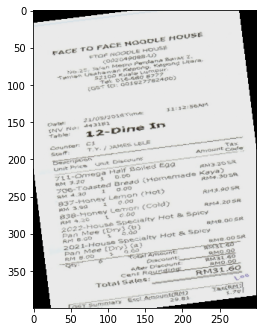

torch.Size([3, 400, 300])
Company: SYARIKAT PERNIAGAAN GIN KEE [NL] NO 290, JALAN AIR PANAS, SETAPAK, 53200, KUALA LUMPUR. ; target: tensor([  180,   476, 22410,   439,  5767,     3,  8742, 26077,  6302,  5033,
            3, 24961,   480,  5080,   784, 18207,   908,  5693,     3, 23838,
            6,     3, 13853, 12303,     3, 18375,  4935, 21277,     6,     3,
        20788, 23649,   439,     6, 12210,  3632,     6,     3, 18519, 23634,
          301, 28468,  5905,     5,     1,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0])


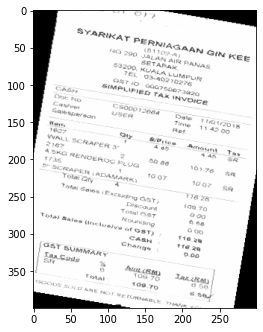

torch.Size([3, 400, 300])
Company: HON HWA HARDWARE TRADING [NL] NO 37, JALAN MANIS 7, TAMAN SEGAR, 56100 CHERAS, KUALA LUMPUR. ; target: tensor([  454,  4170,   454, 12054,     3, 25430, 20293,  7451,   332, 21577,
         2365,   784, 18207,   908,  5693,  6862,     6,     3, 13853, 12303,
            3,  9312,  4555,  7973,     3,  3221,  9312,  5985, 25826,     6,
        11526,  2915,   205, 17444,  3291,     6,     3, 18519, 23634,   301,
        28468,  5905,     5,     1,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0])


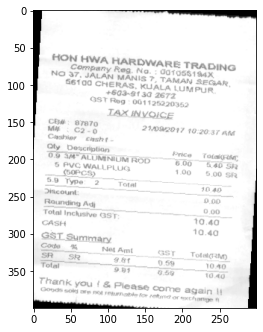

torch.Size([3, 400, 300])
Company: 99 SPEED MART S/B [NL] LOT P.T. 2811, JALAN ANGSA, TAMAN BERKELEY 41150 KLANG, SELANGOR 1313-SUBANG BESTARI ; target: tensor([12185,   180,  5668,  2326,   283,  8241,   180,    87,   279,   784,
        18207,   908,     3, 19912,   276,     5,   382,     5,  2059,  2596,
            6,     3, 13853, 12303,     3, 19775,  4507,     6,     3,  3221,
         9312,     3, 12920,   439, 16479,   476,  8798, 12278,   480, 12303,
          517,     6,     3, 23143, 19775,  2990,  1179,  2368,    18,  4138,
          279, 19775, 23325, 22410,     1,     0,     0,     0,     0,     0,
            0,     0,     0,     0])


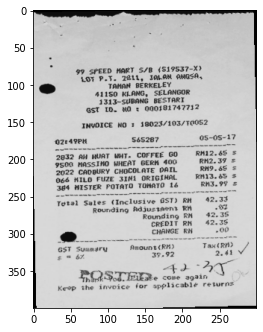

----------------------------------------
Test batch
Company: RESTORAN WAN SHENG [NL] NO.2, JALAN TEMENGGUNG 19/9, SEKSYEN 9, BANDAR MAHKOTA CHERAS, 43200 CHERAS, SELANGOR ; target: tensor([  377,  5647,   371,  5693,  7039,  3765,     3,  6299, 11927,   784,
        18207,   908,  5693,     5,  1828,     6,     3, 13853, 12303,  7934,
        22749,     3,  8742,   308, 15610,  8145, 24400,  3547,     3,  3221,
         9312,  2312,  5478, 28277,   480,  8569, 15628,     6,   480,  8569,
        15628,     3,  6675, 21159,     6,  9065,  2915,     3, 18519, 23634,
          301, 28468,  5905,     5,     1,     0,     0,     0,     0,     0,
            0,     0,     0,     0])


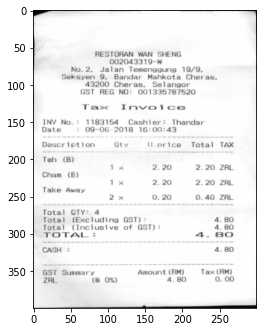

Company: AIK HUAT HARDWARE ENTERPRISE (SETIA ALAM) SDN BHD [NL] NO. 17-G, JALAN SETIA INDAH (X) U13/X, SETIA ALAM, SEKSYEN U13, 40170 SHAH ALAM, ; target: tensor([  180,   476, 22410,   439,  5767,     3,  8742, 26077,  6302,  5033,
            3, 24961,   480,  5080,   784, 18207,   908,  5693,     3, 23838,
            6,     3, 13853, 12303,     3, 18375,  4935, 21277,     6,     3,
        20788, 23649,   439,     6, 12210,  3632,     6,     3, 18519, 23634,
          301, 28468,  5905,     5,     1,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0])


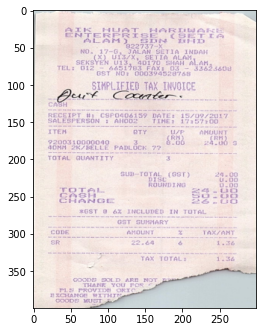

Company: SANYU STATIONERY SHOP [NL] NO. 31G&33G, JALAN SETIA INDAH X ,U13/X 40170 SETIA ALAM ; target: tensor([  454,  4170,   454, 12054,     3, 25430, 20293,  7451,   332, 21577,
         2365,   784, 18207,   908,  5693,  6862,     6,     3, 13853, 12303,
            3,  9312,  4555,  7973,     3,  3221,  9312,  5985, 25826,     6,
        11526,  2915,   205, 17444,  3291,     6,     3, 18519, 23634,   301,
        28468,  5905,     5,     1,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0])


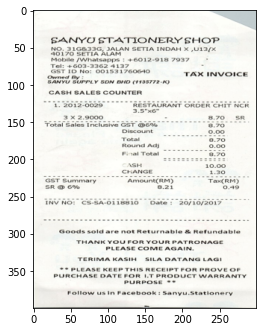

Company: FY EAGLE ENTERPRISE [NL] NO. 42, JALAN PBS 14/11, TAMAN PERINDUSTRIAN BUKIT SERDANG, 43300 SERI KEMBANGAN, SELANGOR ; target: tensor([12185,   180,  5668,  2326,   283,  8241,   180,    87,   279,   784,
        18207,   908,     3, 19912,   276,     5,   382,     5,  2059,  2596,
            6,     3, 13853, 12303,     3, 19775,  4507,     6,     3,  3221,
         9312,     3, 12920,   439, 16479,   476,  8798, 12278,   480, 12303,
          517,     6,     3, 23143, 19775,  2990,  1179,  2368,    18,  4138,
          279, 19775, 23325, 22410,     1,     0,     0,     0,     0,     0,
            0,     0,     0,     0])


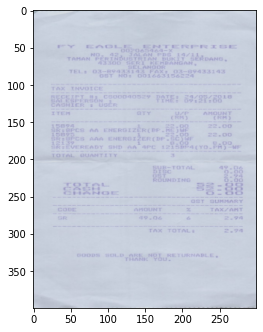

In [21]:
display_dataloaders = {mode: datasets[mode].get_dataloader(batch_size=4, shuffle=True) for mode in MODES}

print(len(display_dataloaders["output/train"]))

# Test-load batchs 
train_batch, test_batch = next(iter(display_dataloaders["output/train"])), next(iter(display_dataloaders["test"]))

print("Train batch")
for image, company, target in zip(train_batch[0], train_batch[1], train_batch[2]):
  print(image.shape)
  plt.figure(figsize=(4, 10))
  print(f"Company: {company}", f"; target: {target}")
  plt.imshow(((image.squeeze(0).cpu().numpy().transpose(1, 2, 0)/2+1)))
  plt.show()  
print('----------------------------------------')

print("Test batch")
for image, company, target in zip(test_batch[0], test_batch[1], train_batch[2]):
  plt.figure(figsize=(4, 10))
  print(f"Company: {company}", f"; target: {target}")
  plt.imshow(((image.squeeze(0).cpu().numpy().transpose(1, 2, 0)/2+1)))
  plt.show()

## Métricas

Usar as funções abaixo para calcular as métricas (exact match e F1):

In [22]:
import collections

def normalize_answer(s):
    """Lower text and remove extra whitespace."""

    def white_space_fix(text):
        return ' '.join(text.split())

    def lower(text):
        return text.lower()

    return white_space_fix(lower(s))

def get_tokens(s):
    if not s: return []
    return normalize_answer(s).split()

def compute_exact(a_gold, a_pred):
    return int(normalize_answer(a_gold) == normalize_answer(a_pred))

def compute_f1(a_gold, a_pred):
    gold_toks = get_tokens(a_gold)
    pred_toks = get_tokens(a_pred)
    common = collections.Counter(gold_toks) & collections.Counter(pred_toks)
    num_same = sum(common.values())
    if len(gold_toks) == 0 or len(pred_toks) == 0:
        # If either is no-answer, then F1 is 1 if they agree, 0 otherwise
        return int(gold_toks == pred_toks)
    if num_same == 0:
        return 0
    precision = 1.0 * num_same / len(pred_toks)
    recall = 1.0 * num_same / len(gold_toks)
    f1 = (2 * precision * recall) / (precision + recall)
    return f1

# Definir a classe do modelo usado EfficientT5

In [23]:
"""
Code borrowed with thanks from:
https://github.com/ndrplz/ConvLSTM_pytorch
https://github.com/shreyaspadhy/UNet-Zoo/blob/master/CLSTM.py
https://gist.github.com/halochou/acbd669af86ecb8f988325084ba7a749
"""

import torch.nn as nn
import torch


class ConvGRUCell(nn.Module):
    """
    Basic CGRU cell.
    """

    def __init__(self, in_channels, hidden_channels, kernel_size, bias):

        super(ConvGRUCell, self).__init__()

        self.input_dim  = in_channels
        self.hidden_dim = hidden_channels

        self.kernel_size = kernel_size
        self.padding = kernel_size[0] // 2, kernel_size[1] // 2
        self.bias = bias
        self.update_gate = nn.Conv2d(in_channels=self.input_dim+self.hidden_dim, out_channels=self.hidden_dim,
                                     kernel_size=self.kernel_size, padding=self.padding,
                                     bias=self.bias)
        self.reset_gate = nn.Conv2d(in_channels=self.input_dim+self.hidden_dim, out_channels=self.hidden_dim,
                                    kernel_size=self.kernel_size, padding=self.padding,
                                    bias=self.bias)

        self.out_gate = nn.Conv2d(in_channels=self.input_dim+self.hidden_dim, out_channels=self.hidden_dim,
                                  kernel_size=self.kernel_size, padding=self.padding,
                                  bias=self.bias)

    def forward(self, input_tensor, cur_state):

        h_cur = cur_state
        # data size is [batch, channel, height, width]
        x_in = torch.cat([input_tensor, h_cur], dim=1)
        update = torch.sigmoid(self.update_gate(x_in))
        reset = torch.sigmoid(self.reset_gate(x_in))
        x_out = torch.tanh(self.out_gate(torch.cat([input_tensor, h_cur * reset], dim=1)))
        h_new = h_cur * (1 - update) + x_out * update

        return h_new

    def init_hidden(self, b, h, w):
        return torch.zeros(b, self.hidden_dim, h, w).cuda()


class ConvGRU(nn.Module):

    def __init__(self, in_channels, hidden_channels, kernel_size, num_layers,
                 batch_first=False, bias=True, return_all_layers=False):
        super(ConvGRU, self).__init__()

        self._check_kernel_size_consistency(kernel_size)

        # Make sure that both `kernel_size` and `hidden_dim` are lists having len == num_layers
        kernel_size = self._extend_for_multilayer(kernel_size, num_layers)
        hidden_channels = self._extend_for_multilayer(hidden_channels, num_layers)
        if not len(kernel_size) == len(hidden_channels) == num_layers:
            raise ValueError('Inconsistent list length.')

        self.input_dim  = in_channels
        self.hidden_dim = hidden_channels
        self.kernel_size = kernel_size
        self.num_layers = num_layers
        self.batch_first = batch_first
        self.bias = bias
        self.return_all_layers = return_all_layers

        cell_list = []
        for i in range(0, self.num_layers):
            cur_input_dim = self.input_dim if i == 0 else self.hidden_dim[i-1]

            cell_list.append(ConvGRUCell(in_channels=cur_input_dim,
                                          hidden_channels=self.hidden_dim[i],
                                          kernel_size=self.kernel_size[i],
                                          bias=self.bias))

        self.cell_list = nn.ModuleList(cell_list)

    def forward(self, input_tensor, hidden_state=None):
        """
        Parameters
        ----------
        input_tensor: todo
            5-D Tensor either of shape (t, b, c, h, w) or (b, t, c, h, w)
        hidden_state: todo
            None. todo implement stateful
        Returns
        -------
        last_state_list, layer_output
        """
        if not self.batch_first:
            # (t, b, c, h, w) -> (b, t, c, h, w)
            input_tensor = input_tensor.permute(1, 0, 2, 3, 4)

        # Implement stateful ConvGRU
        if hidden_state is not None:
            raise NotImplementedError()
        else:
            b, _, _, h, w = input_tensor.shape
            hidden_state = self._init_hidden(b, h, w)

        layer_output_list = []
        last_state_list   = []

        seq_len = input_tensor.size(1)
        cur_layer_input = input_tensor

        for layer_idx in range(self.num_layers):

            h = hidden_state[layer_idx]
            output_inner = []
            for t in range(seq_len):

                h = self.cell_list[layer_idx](input_tensor=cur_layer_input[:, t, :, :, :],
                                                 cur_state=h)
                output_inner.append(h)

            layer_output = torch.stack(output_inner, dim=1)
            cur_layer_input = layer_output

            layer_output_list.append(layer_output)
            last_state_list.append(h)

        if not self.return_all_layers:
            layer_output_list = layer_output_list[-1:]
            last_state_list = last_state_list[-1:]

        return layer_output_list, last_state_list

    def _init_hidden(self, b, h, w):
        init_states = []
        for i in range(self.num_layers):
            init_states.append(self.cell_list[i].init_hidden(b, h, w))
        return init_states

    @staticmethod
    def _check_kernel_size_consistency(kernel_size):
        if not (isinstance(kernel_size, tuple) or
                    (isinstance(kernel_size, list) and all([isinstance(elem, tuple) for elem in kernel_size]))):
            raise ValueError('`kernel_size` must be tuple or list of tuples')

    @staticmethod
    def _extend_for_multilayer(param, num_layers):
        if not isinstance(param, list):
            param = [param] * num_layers
        return param


class ConvBGRU(nn.Module):
    # Constructor
    def __init__(self, in_channels, hidden_channels,
                 kernel_size, num_layers, bias=True, batch_first=False):

        super(ConvBGRU, self).__init__()
        self.forward_net = ConvGRU(in_channels, hidden_channels//2, kernel_size,
                                    num_layers, batch_first=batch_first, bias=bias)
        self.reverse_net = ConvGRU(in_channels, hidden_channels//2, kernel_size,
                                    num_layers, batch_first=batch_first, bias=bias)

    def forward(self, xforward, xreverse):
        """
        xforward, xreverse = B T C H W tensors.
        """

        y_out_fwd, _ = self.forward_net(xforward)
        y_out_rev, _ = self.reverse_net(xreverse)

        y_out_fwd = y_out_fwd[-1] # outputs of last CGRU layer = B, T, C, H, W
        y_out_rev = y_out_rev[-1] # outputs of last CGRU layer = B, T, C, H, W

        reversed_idx = list(reversed(range(y_out_rev.shape[1])))
        y_out_rev = y_out_rev[:, reversed_idx, ...] # reverse temporal outputs.
        ycat = torch.cat((y_out_fwd, y_out_rev), dim=2)

        return ycat


In [24]:
"""
Code borrowed with thanks from:
Shreyas Padhy, and Andrea Palazzi
https://github.com/ndrplz/ConvLSTM_pytorch
https://github.com/shreyaspadhy/UNet-Zoo/blob/master/CLSTM.py
"""

import torch.nn as nn
import torch


class ConvLSTMCell(nn.Module):
    """
    Basic CLSTM cell.
    """

    def __init__(self, in_channels, hidden_channels, kernel_size, bias):

        super(ConvLSTMCell, self).__init__()

        self.input_dim  = in_channels
        self.hidden_dim = hidden_channels

        self.kernel_size = kernel_size
        self.padding = kernel_size[0] // 2, kernel_size[1] // 2
        self.bias = bias
        
        self.conv = nn.Conv2d(in_channels=self.input_dim + self.hidden_dim,
                              out_channels=4 * self.hidden_dim,
                              kernel_size=self.kernel_size,
                              padding=self.padding,
                              bias=self.bias)

    def forward(self, input_tensor, cur_state):
        
        h_cur, c_cur = cur_state
        
        combined = torch.cat([input_tensor, h_cur], dim=1)  # concatenate along channel axis
        
        combined_conv = self.conv(combined)
        cc_i, cc_f, cc_o, cc_g = torch.split(combined_conv, self.hidden_dim, dim=1) 
        i = torch.sigmoid(cc_i)
        f = torch.sigmoid(cc_f)
        o = torch.sigmoid(cc_o)
        g = torch.tanh(cc_g)

        c_next = f * c_cur + i * g
        h_next = o * torch.tanh(c_next)
        
        return h_next, c_next

    def init_hidden(self, b, h, w):
        return (torch.zeros(b, self.hidden_dim, h, w).cuda(),
                torch.zeros(b, self.hidden_dim, h, w).cuda())


class ConvLSTM(nn.Module):

    def __init__(self, in_channels, hidden_channels, kernel_size, num_layers,
                 batch_first=False, bias=True, return_all_layers=False):
        super(ConvLSTM, self).__init__()

        self._check_kernel_size_consistency(kernel_size)

        # Make sure that both `kernel_size` and `hidden_dim` are lists having len == num_layers
        kernel_size = self._extend_for_multilayer(kernel_size, num_layers)
        hidden_channels = self._extend_for_multilayer(hidden_channels, num_layers)
        if not len(kernel_size) == len(hidden_channels) == num_layers:
            raise ValueError('Inconsistent list length.')

        self.input_dim  = in_channels
        self.hidden_dim = hidden_channels
        self.kernel_size = kernel_size
        self.num_layers = num_layers
        self.batch_first = batch_first
        self.bias = bias
        self.return_all_layers = return_all_layers

        cell_list = []
        for i in range(0, self.num_layers):
            cur_input_dim = self.input_dim if i == 0 else self.hidden_dim[i-1]

            cell_list.append(ConvLSTMCell(in_channels=cur_input_dim,
                                          hidden_channels=self.hidden_dim[i],
                                          kernel_size=self.kernel_size[i],
                                          bias=self.bias))

        self.cell_list = nn.ModuleList(cell_list)

    def forward(self, input_tensor, hidden_state=None):
        """
        Parameters
        ----------
        input_tensor: todo
            5-D Tensor either of shape (t, b, c, h, w) or (b, t, c, h, w)
        hidden_state: todo
            None. todo implement stateful
        Returns
        -------
        last_state_list, layer_output
        """
        if not self.batch_first:
            # (t, b, c, h, w) -> (b, t, c, h, w)
            input_tensor = input_tensor.permute(1, 0, 2, 3, 4)

        # Implement stateful ConvLSTM
        if hidden_state is not None:
            raise NotImplementedError()
        else:
            b, _, _, h, w = input_tensor.shape
            hidden_state = self._init_hidden(b, h, w)

        layer_output_list = []
        last_state_list   = []

        seq_len = input_tensor.size(1)
        cur_layer_input = input_tensor

        for layer_idx in range(self.num_layers):

            h, c = hidden_state[layer_idx]
            output_inner = []
            for t in range(seq_len):

                h, c = self.cell_list[layer_idx](input_tensor=cur_layer_input[:, t, :, :, :],
                                                 cur_state=[h, c])
                output_inner.append(h)

            layer_output = torch.stack(output_inner, dim=1)
            cur_layer_input = layer_output

            layer_output_list.append(layer_output)
            last_state_list.append([h, c])

        if not self.return_all_layers:
            layer_output_list = layer_output_list[-1:]
            last_state_list = last_state_list[-1:]

        return layer_output_list, last_state_list

    def _init_hidden(self, b, h, w):
        init_states = []
        for i in range(self.num_layers):
            init_states.append(self.cell_list[i].init_hidden(b, h, w))
        return init_states

    @staticmethod
    def _check_kernel_size_consistency(kernel_size):
        if not (isinstance(kernel_size, tuple) or
                    (isinstance(kernel_size, list) and all([isinstance(elem, tuple) for elem in kernel_size]))):
            raise ValueError('`kernel_size` must be tuple or list of tuples')

    @staticmethod
    def _extend_for_multilayer(param, num_layers):
        if not isinstance(param, list):
            param = [param] * num_layers
        return param


class ConvBLSTM(nn.Module):
    # Constructor
    def __init__(self, in_channels, hidden_channels,
                 kernel_size, num_layers, bias=True, batch_first=False):

        super(ConvBLSTM, self).__init__()
        self.forward_net = ConvLSTM(in_channels, hidden_channels//2, kernel_size,
                                    num_layers, batch_first=batch_first, bias=bias)
        self.reverse_net = ConvLSTM(in_channels, hidden_channels//2, kernel_size,
                                    num_layers, batch_first=batch_first, bias=bias)
        
    def forward(self, xforward, xreverse):
        """
        xforward, xreverse = B T C H W tensors.
        """

        y_out_fwd, _ = self.forward_net(xforward)
        y_out_rev, _ = self.reverse_net(xreverse)

        y_out_fwd = y_out_fwd[-1] # outputs of last CLSTM layer = B, T, C, H, W
        y_out_rev = y_out_rev[-1] # outputs of last CLSTM layer = B, T, C, H, W

        reversed_idx = list(reversed(range(y_out_rev.shape[1])))
        y_out_rev = y_out_rev[:, reversed_idx, ...] # reverse temporal outputs.
        ycat = torch.cat((y_out_fwd, y_out_rev), dim=2)
        
        return ycat

In [25]:
def set_bn_eval(m):
    classname = m.__class__.__name__
    if classname.find('BatchNorm2d') != -1:
        print('freezing ', m)
        m.eval()

In [26]:
class EfficientT5(pl.LightningModule):

    def __init__(self, params):
        super(EfficientT5, self).__init__()

        self.params = params
        
        override_params = {'dropout_rate':params['dropout_rate'],'drop_connect_rate':params['drop_connect_rate']}

        # Features da efficient net atuarão como as features do encoder do T5
        self.encoder = EfficientNet.from_pretrained(params['enet'], advprop=True, **override_params)
        # freeze BN
        self.encoder = self.encoder.apply(set_bn_eval)
        
        
        self.decoder = T5ForConditionalGeneration.from_pretrained(params['t5'])
        self.bridge = ConvGRU(in_channels=int(112/2), hidden_channels=self.decoder.config.d_model, kernel_size=(3, 3), num_layers=1, batch_first=True)

        self.tokenizer = TOKENIZER

    def _get_efn_embeddings(self, images):

        # Shape (N, 112, 16, 16)
        # features = self.encoder.extract_features(images)
        features = self.encoder.extract_endpoints(images)["reduction_4"]
        # print('features shape', features.shape)

        features = features.unsqueeze(1)

        
        # features = features.reshape(features.shape[0], 1, 112, 25, 19) #best

        features = features.reshape(features.shape[0], 2, int(112/2), 25, 19)

        # Shape: (N, 512, -, -)
        features, last_state_list = self.bridge(features)
        
        features = features[0]

        # Shape: (N, -1, 512) -> Pra ficar do shape de entrada do decoder que é (N, seq_len, d_model)
        efn_embeddings = features \
            .permute(0, 1, 3, 4, 2) \
            .reshape(features.shape[0], -1, self.decoder.config.d_model)

        return efn_embeddings

    
    def _generate_tokens(self, efn_embeddings):
        '''
        Token generation
        '''
        max_length = self.params['seq_len']

        # Add start of sequence token
        decoded_ids = torch.full((efn_embeddings.shape[0], 1),
                                 self.decoder.config.decoder_start_token_id,
                                 dtype=torch.long).to(efn_embeddings.device)
        
        encoder_hidden_states = self.decoder.get_encoder()(inputs_embeds=efn_embeddings)

        for step in range(max_length-1):
            logits = self.decoder(decoder_input_ids=decoded_ids,
                                  encoder_outputs=encoder_hidden_states)[0]
            next_token_logits = logits[:, -1, :]

            # decoding
            next_token_id = next_token_logits.argmax(1).unsqueeze(-1)
            
            # Check if output is end of senquence for all batches
            if torch.eq(next_token_id[:, -1], self.tokenizer.eos_token_id).all():
                break

            # Concatenate past ids with new id, keeping batch dimension
            decoded_ids = torch.cat([decoded_ids, next_token_id], dim=-1)

        return decoded_ids

    def forward(self, batch): # TODO pro futuro: colocar os dados necessários individualmente e não o batch inteiro
        # Aqui os labels são strings e os tokens são os labels a serem inseridos no decoder
        # print(len(batch))
        images, label, token = batch

        # Output do efn atua como embedding do encoder
        efn_embeddings = self._get_efn_embeddings(images)
        # print('efn_embeddings', efn_embeddings.shape)

        if self.training:
            outputs = self.decoder(inputs_embeds=efn_embeddings,
                                   decoder_input_ids=None, 
                                   labels=token,
                                   return_dict=True)
            return outputs.loss
        else:
            return self._generate_tokens(efn_embeddings)

    def training_step(self, batch, batch_idx): 
        loss = self(batch)
        self.log('loss', loss, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        pred_tokens = self(batch)
        # Tokens -> String
        decoded_pred = [self.tokenizer.decode(tokens) for tokens in pred_tokens]
        
        images, label, token = batch

        efn_embeddings = self._get_efn_embeddings(images)

        outputs = self.decoder(inputs_embeds=efn_embeddings,
                                decoder_input_ids=None, 
                                labels=token,
                                return_dict=True)

        val_loss = outputs.loss.detach().cpu().numpy()

        return {"val_loss": val_loss, "pred": decoded_pred, "target": batch[1]}

    def test_step(self, batch, batch_idx):
        pred_tokens = self(batch)
        # Tokens -> String
        decoded_pred = [self.tokenizer.decode(tokens) for tokens in pred_tokens]
        
        images, label, token = batch

        efn_embeddings = self._get_efn_embeddings(images)

        outputs = self.decoder(inputs_embeds=efn_embeddings,
                                decoder_input_ids=None, 
                                labels=token,
                                return_dict=True)

        test_loss = outputs.loss.detach().cpu().numpy()

        return {"test_loss": test_loss, "pred": decoded_pred, "target": batch[1]}


    def validation_epoch_end(self, outputs):
        # Flatten dos targets e preds para arrays
        trues = sum([list(x['target']) for x in outputs], [])
        preds = sum([list(x['pred']) for x in outputs], [])

        # n = random.choice(range(len(trues)))
        n_samples = random.sample(range(len(trues)), 1)
        for n in n_samples:
            print(f"\nSample Target: {trues[n]}\nPrediction: {preds[n]}\n")
        
        f1 = []
        exact = []
        for true, pred in zip(trues, preds):
            f1.append(compute_f1(a_gold=true, a_pred=pred))
            exact.append(compute_exact(a_gold=true, a_pred=pred))
        f1 = np.mean(f1)
        exact = np.mean(exact)

        bleu = sacrebleu.corpus_bleu(preds, [trues])

        val_loss = sum([x['val_loss'] for x in outputs])/len(outputs)

        self.log("val_loss", val_loss, prog_bar=True)

        self.log("val_bleu_score", bleu.score, prog_bar=True)
        self.log("val_bleu_1", bleu.precisions[0], prog_bar=True)
        self.log("val_bleu_4", bleu.precisions[3], prog_bar=True)
        self.log("val_f1", f1, prog_bar=True)
        self.log("val_exact", exact, prog_bar=True)

        return {'val_f1': f1, 'val_loss': val_loss}

    def test_epoch_end(self, outputs):
        # Flatten dos targets e preds para arrays
        trues = sum([list(x['target']) for x in outputs], [])
        preds = sum([list(x['pred']) for x in outputs], [])

        n = random.choice(range(len(trues)))
        print(f"\nSample Target: {trues[n]}\nPrediction: {preds[n]}\n")

        f1 = []
        exact = []
        for true, pred in zip(trues, preds):
            f1.append(compute_f1(a_gold=true, a_pred=pred))
            exact.append(compute_exact(a_gold=true, a_pred=pred))
        f1 = np.mean(f1)
        exact = np.mean(exact)

        bleu = sacrebleu.corpus_bleu(preds, [trues])

        test_loss = sum([x['test_loss'] for x in outputs])/len(outputs)
        
        self.log("test_loss", test_loss, prog_bar=True)
        self.log("test_bleu_score", bleu.score, prog_bar=True)
        self.log("test_bleu_1", bleu.precisions[0], prog_bar=True)
        self.log("test_bleu_4", bleu.precisions[3], prog_bar=True)
        self.log("test_f1", f1, prog_bar=True)
        self.log("test_exact", exact, prog_bar=True)
    
    def configure_optimizers(self):
        optimizer = adafactor.Adafactor(self.parameters(), weight_decay=0.001, scale_parameter=False, eps=(1e-30, self.params['lr']),
                                        lr=self.params['lr'], relative_step=False)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2)
        return {'optimizer': optimizer, 'lr_scheduler': scheduler, 'monitor':'val_loss'}
    
    def train_dataloader(self):
        return datasets["output/train"].get_dataloader(batch_size=self.params['bs'], shuffle=True)
    def val_dataloader(self):
        return datasets["output/val"].get_dataloader(batch_size=self.params['bs'], shuffle=False)    
    def test_dataloader(self):
        return datasets["test"].get_dataloader(batch_size=self.params['bs'], shuffle=False)

# Definir os hiper-parametros do modelo
## Diversos hiper-parametros foram testados, mas os melhores valores foram obtidos com os parametros abaixo 


**Os parâmetros de *dropout_rate* e *drop_connect_rate* da efficient-net são bastante interessantes podendo dar um maior domínio sobre a efficiente-net**

In [ ]:
neptune_logger = NeptuneLogger(
    api_key="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vdWkubmVwdHVuZS5haSIsImFwaV91cmwiOiJodHRwczovL3VpLm5lcHR1bmUuYWkiLCJhcGlfa2V5IjoiYzJiZGU4NWMtZDI0NS00ZjIxLWIwZmMtZDI1ZTJjMTg3MjE4In0=",
    project_name="orllem/ocr-recibos-fine-tuning-augment-newvalidation",
    params=hparams)

In [27]:

# Initialize Lightning Module with parameters defined above.
# model = EfficientT5(hparams)
pre_model = "drive/My Drive/aula13_checkpoints_drive/finetuning_augm_extract_app3_adafactor_seqred_test1-epoch=39-step=1799.ckpt"
# pre_model = "drive/My Drive/aula13_checkpoints_drive/finetuning_augm_extract_app4_adafactor_seqred_test1-epoch=38-step=1754.ckpt"
model = EfficientT5(hparams).load_from_checkpoint(pre_model, params=hparams)
print(model)

# Configure callbacks
if hparams["debug"]:
  checkpoint_callback = None
  logger = None
  early_stop_callback = None
else:
  checkpoint_path = 'drive/My Drive/aula13_checkpoints_drive/epoch=10.ckpt'
  checkpoint_dir = os.path.dirname(os.path.abspath(checkpoint_path))
  print(f'Files in {checkpoint_dir}: {os.listdir(checkpoint_dir)}')
  print(f'Saving checkpoints to {checkpoint_dir}')
  checkpoint_callback = pl.callbacks.ModelCheckpoint(prefix=hparams["version"],
                                                      filepath=checkpoint_dir,
                                                      save_top_k=1, 
                                                      monitor="val_loss", mode="min")
  early_stop_callback = pl.callbacks.EarlyStopping(monitor='val_loss', patience=hparams["patience"], mode='min')

trainer = pl.Trainer(gpus=1,
                     fast_dev_run=hparams["debug"],
                     accumulate_grad_batches=hparams["accum"],
                     # logger=neptune_logger,
                     checkpoint_callback=checkpoint_callback, 
                     callbacks=[early_stop_callback],
                     max_epochs=hparams["max_epochs"])

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/adv-efficientnet-b0-b64d5a18.pth" to /root/.cache/torch/hub/checkpoints/adv-efficientnet-b0-b64d5a18.pth



Loaded pretrained weights for efficientnet-b0
freezing  BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
freezing  BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
freezing  BatchNorm2d(16, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
freezing  BatchNorm2d(96, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
freezing  BatchNorm2d(96, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
freezing  BatchNorm2d(24, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
freezing  BatchNorm2d(144, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
freezing  BatchNorm2d(144, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
freezing  BatchNorm2d(24, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_


Loaded pretrained weights for efficientnet-b0
freezing  BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
freezing  BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
freezing  BatchNorm2d(16, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
freezing  BatchNorm2d(96, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
freezing  BatchNorm2d(96, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
freezing  BatchNorm2d(24, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
freezing  BatchNorm2d(144, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
freezing  BatchNorm2d(144, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
freezing  BatchNorm2d(24, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_

/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: Checkpoint directory /content/drive/My Drive/aula13_checkpoints_drive exists and is not empty.
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: You have set progress_bar_refresh_rate < 20 on Google Colab. This may crash. Consider using progress_bar_refresh_rate >= 20 in Trainer.
  warnings.warn(*args, **kwargs)
GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


EfficientT5(
  (encoder): EfficientNet(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
    )
    (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
          (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
        )
        (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          32, 8, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          8, 32, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_

In [ ]:
trainer.fit(model)


  | Name    | Type                       | Params
-------------------------------------------------------
0 | encoder | EfficientNet               | 5.3 M 
1 | decoder | T5ForConditionalGeneration | 60.5 M
2 | bridge  | ConvGRU                    | 7.9 M 
-------------------------------------------------------
73.6 M    Trainable params
0         Non-trainable params
73.6 M    Total params



Sample Target: FARMASI MALURI S/B [NL] 23, JIN BURUNG JENTAYU, TMN BUKIT MALURI, KEPONG, 52100 KL.
Prediction: BT BREAK LETT SDN BHD [NL] LOT, JALAN SERRA JALAN SERRA



/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The validation_epoch_end should not return anything as of 9.1. To log, use self.log(...) or self.write(...) directly in the LightningModule
  warnings.warn(*args, **kwargs)



Sample Target: IKANO HANDEL SDN BHD [NL] NO 2A JALAN COCHRANE TAMAN MALURI 55100 KUALA LUMPUR
Prediction: MR. D.L. JALAN SCHN BHD [NL] LOT 3, 3, JALAN JALAN JALAN JALAN JALAN JALAN JALAN JALAN JALAN JALAN JALAN JALAN JALAN JA



Failed to send channel value.
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-25. Cause: Error(code=400, message='X-coordinates must be strictly increasing for channel: dfaa8180-4887-4b1f-90f3-d200218d0952.


Sample Target: MR. D.I.Y. (M) SDN BHD [NL] LOT 1851-A & 1851-B, JALAN KPB 6, KAWASAN PERINDUSTRIAN BALAKONG, 43300 SERI KEMBANGAN, SELANGOR
Prediction: MR. D.I.Y. (M) SDN BHD [NL] LOT 1851-A & 1851-B, JALAN KPB 6, KAWASAN PERINDUSTRIAN BALAKONG, 43300 SERI KEMBANGAN,



Failed to send channel value.
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-25. Cause: Error(code=400, message='X-coordinates must be strictly increasing for channel: dfaa8180-4887-4b1f-90f3-d200218d0952.


Sample Target: SEGI CASH & CARRY SDN.BHD [NL] PT17920, SEKSYEN U9, 40150 SHAH ALAM, SELANGOR DARUL EHSAN.
Prediction: DOWNLAND FRIEND FRIEND [NL] NO.3 JALAN TAX TAX TAX TAX TAX TAX TAX TAX TAX TAX TAX TAX TAX TAX TAX



Failed to send channel value.
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-25. Cause: Error(code=400, message='X-coordinates must be strictly increasing for channel: dfaa8180-4887-4b1f-90f3-d200218d0952.


Sample Target: AEON CO. (M) BHD. [NL] 3RD FLR, AEON TAMAN MALURI SC JLN JEJAKA, TAMAN MALURI CHERAS ,55100 KUALA LUMPUR
Prediction: KEYS & CO. (M) BHD [NL] 3RD FLR. JOLAN, TAHAH MALUSE octan JOLAN, JALAN, TAHAH MALUSE



Failed to send channel value.
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-25. Cause: Error(code=400, message='X-coordinates must be strictly increasing for channel: dfaa8180-4887-4b1f-90f3-d200218d0952.


Sample Target: GREEN LANE PHARMACY SDN BHD [NL] 33 JLN BANGAU 1,KEPONG BARU, 52100 KEPONG,KL
Prediction: SELERA LONG RANGE [NL] SCO & JALAN JALAN BRAND, SELARA



Failed to send channel value.
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-25. Cause: Error(code=400, message='X-coordinates must be strictly increasing for channel: dfaa8180-4887-4b1f-90f3-d200218d0952.


Sample Target: GERBANG ALAF RESTAURANTS SDN BHD [NL] LEVEL 6, BANGUNAN TH, DAMANSARA UPTOWN3 NO.3, JALAN SS21/39, 47400 PETALING JAYA SELANGOR
Prediction: GERMANY ALAF EXECUTIVES SDN BHD [NL] LIVES, 6, ENGINEERING TX, BERMANSA UPPRESS NO.3, JALAN SELLIN/UP, 47400 PETITING JAYA SELANG



Failed to send channel value.
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-25. Cause: Error(code=400, message='X-coordinates must be strictly increasing for channel: dfaa8180-4887-4b1f-90f3-d200218d0952.


Sample Target: AMPANG 210 FIRST CITY PARKING SDN BHD [NL] A-09-10 PRIMA AVENUE THE TUBE, 1/39, DATARAN PRIMA 47301 PETALING JAYA SELANGOR DE
Prediction: PUMP COMPLY PRESENT SDN BHD [NL] AP-AP-AP-AP-AP-AP-AP-AP-AP-AP-AP-AP-AP-AP-AP-AP-AP-AP-AP-AP-AP-AP-AP-AP-



Failed to send channel value.
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-25. Cause: Error(code=400, message='X-coordinates must be strictly increasing for channel: dfaa8180-4887-4b1f-90f3-d200218d0952.


Sample Target: ELKEN SERVICE SDN BHD [NL] NO 2-1 JALAN 3/137B BATU 5 JALAN KELANG LAMA 58000 KUALA LUMPUR
Prediction: ELKEN SEND BHD [NL] NO 1-3, JALAN 3/3/35 BATTA JALAN KUALA LUMPUR



Failed to send channel value.
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-25. Cause: Error(code=400, message='X-coordinates must be strictly increasing for channel: dfaa8180-4887-4b1f-90f3-d200218d0952.


Sample Target: LIGHTROOM GALLERY SDN BHD [NL] NO: 28,JALAN ASTANA 1C, BANDAR BUKIT RAJA, 41050 KLANG SELANGOR D.E, MALAYSIA
Prediction: LIGHTONG GALLERY SDN BHD [NL] NO. 28, JALAN AUTRA 16, JALAN BURKE KAKA 45300 KLANG SELANGOR D.E. MALAYSIA



Failed to send channel value.
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-25. Cause: Error(code=400, message='X-coordinates must be strictly increasing for channel: dfaa8180-4887-4b1f-90f3-d200218d0952.


Sample Target: GERBANG ALAF RESTAURANTS SDN BHD [NL] LEVEL 6, BANGUNAN TH, DAMANSARA UPTOWN3 NO.3, JALAN SS21/39, 47400 PETALING JAYA SELANGOR
Prediction: GERMANY ALAF EXECUTIVES SDN BHD [NL] LIVES, 6, ENGINEERING TX, BERMANSA UPPRESS NO.3, JALAN SELLIN/UP, 47400 PETITING JAYA SELANG



Failed to send channel value.
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-25. Cause: Error(code=400, message='X-coordinates must be strictly increasing for channel: dfaa8180-4887-4b1f-90f3-d200218d0952.


Sample Target: SYARIKAT PERNIAGAAN GIN KEE [NL] NO 290, JALAN AIR PANAS, SETAPAK, 53200, KUALA LUMPUR.
Prediction: SYARIKAT PERNIAGAAN GIN KEE [NL] NO 290, JALAN AIR PANAS, SETAPAK, 53200, KUALA LUMPUR.



Failed to send channel value.
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-25. Cause: Error(code=400, message='X-coordinates must be strictly increasing for channel: dfaa8180-4887-4b1f-90f3-d200218d0952.


Sample Target: MR. D.I.Y. (M) SDN BHD [NL] LOT 1851-A & 1851-B, JALAN KPB 6, KAWASAN PERINDUSTRIAN BALAKONG, 43300 SERI KEMBANGAN, SELANGOR
Prediction: MR. D.I.Y. (M) SDN BHD [NL] LOT 1851-A & 1851-B, JALAN KPB 6, KAWASAN PERINDUSTRIAN BALAKONG, 43300 SERI KEMBANGAN,



Failed to send channel value.
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-25. Cause: Error(code=400, message='X-coordinates must be strictly increasing for channel: dfaa8180-4887-4b1f-90f3-d200218d0952.


Sample Target: CHECKERS HYPERMARKET SDN BHD (JALAN KLANG LAMA) [NL] LOT 2942 & 2945, JLN SERI SENTOSA 8, SERI SENTOSA, OFF JLN KLANG LAMA, 58000 KUALA LUMPUR.
Prediction: PRESENTATION SAN DIEGO (JALAN ALAN ALAN ALAN ALAN ALAN ALAN ALAN ALAN ALAN ALAN ALAN ALAN ALAN ALAN ALAN ALAN ALAN ALAN ALAN ALAN ALAN ALAN ALAN ALAN ALAN A



Failed to send channel value.
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-25. Cause: Error(code=400, message='X-coordinates must be strictly increasing for channel: dfaa8180-4887-4b1f-90f3-d200218d0952.


Sample Target: POPULAR BOOK CO. (M) SDN BHD [NL] NO 8, JALAN 7/118B, DESA TUN RAZAK 56000 KUALA LUMPUR, MALAYSIA
Prediction: POPULAR SOPU CO. (M) SDN BHD [NL] NO 8, JALAN 7/118B, DESA TUN RAZAK 5400 KUALA LUMPUR, MALAYSIA



Failed to send channel value.
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-25. Cause: Error(code=400, message='X-coordinates must be strictly increasing for channel: dfaa8180-4887-4b1f-90f3-d200218d0952.


Sample Target: YONG CEN ENTERPRISE [NL] 9, JALAN SUBANG JASA 3, 40150 SHAN ALAM, SELANGOR.
Prediction: YONG CEN ENTERPRISE [NL] 6, JALAN SUNGANG JAJA 3, 40140 SHAH ALAM, SELANGOR.



Failed to send channel value.
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-25. Cause: Error(code=400, message='X-coordinates must be strictly increasing for channel: dfaa8180-4887-4b1f-90f3-d200218d0952.


Sample Target: PREMIO STATIONERY SDN BHD [NL] F-G-01 JALAN SS 6/5B DATARAN GLOMAC. KELANA JAYA 47301 PETALING JAYA. SELANGOR
Prediction: FREEMAN STATEMENT SDN BHD [NL] 5-2-G JALAN SK 9/76 DILATAN GLOMAS, KUALAALA JAYA 47101 PETALING JAYA, SELANGOR



Failed to send channel value.
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-25. Cause: Error(code=400, message='X-coordinates must be strictly increasing for channel: dfaa8180-4887-4b1f-90f3-d200218d0952.


Sample Target: 99 SPEED MART S/B [NL] LOT P. T. 2811, JALAN ANGSA, TAMAN BERKELEY 41150 KLANG, SELANGOR 1934-LAMAN RIMBUNAN
Prediction: 99 SPEED MART S/B [NL] LOT P. T. 2811, JALAN ANGSA, TAMAN BERKELEY 41150 KLANG, SELANGOR 1924-TAMAN SELANGOR



Failed to send channel value.
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-25. Cause: Error(code=400, message='X-coordinates must be strictly increasing for channel: dfaa8180-4887-4b1f-90f3-d200218d0952.


Sample Target: 99 SPEED MART S/B [NL] LOT P.T. 2811, JALAN ANGSA, TAMAN BERKELEY 41150 KLANG, SELANGOR 1317 TRILLIUM S6 BESI
Prediction: 99 SPEED MART S/B [NL] LOT P.T. 2811, JALAN ANGSA, TAMAN BERKELEY 41150 KLANG, SELANGOR 1317 SELANGOR



Failed to send channel value.
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-25. Cause: Error(code=400, message='X-coordinates must be strictly increasing for channel: dfaa8180-4887-4b1f-90f3-d200218d0952.


Sample Target: GARDENIA BAKERIES (KL) SDN BHD [NL] LOT 3, JALAN PELABUR 23/1, 40300 SHAH ALAM, SELANGOR.
Prediction: GARDENIA BAKERIES (KL) SDN BHD [NL] LOT 3, JALAN PELABUR 23/1, 40300 SHAH ALAM, SELANGOR.



Failed to send channel value.
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-25. Cause: Error(code=400, message='X-coordinates must be strictly increasing for channel: dfaa8180-4887-4b1f-90f3-d200218d0952.


Sample Target: PAPPARICH BMC [NL] JALAN TEMENGGUNG 23/9 BANDAR MAHKOTA CHERAS 43200 SELANGOR DARUL EHSAN, MALAYSIA
Prediction: PAPAGAN BRAND [NL] JALAN TERENGENGENG 2/10 BANDAN MARQUTA CORDAN 82300 SELANGOR DARZA DEASAN



Failed to send channel value.
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-25. Cause: Error(code=400, message='X-coordinates must be strictly increasing for channel: dfaa8180-4887-4b1f-90f3-d200218d0952.


Sample Target: UNIHAKKA INTERNATIONAL SDN BHD [NL] 12, JALAN TAMPOI 7/4,KAWASAN PERINDUSTRIAN TAMPOI,81200 JOHOR BAHRU,JOHOR
Prediction: UNIHAKKA INTERNATIONAL SDN BHD [NL] 12, JALAN TAMPOI 7/4,KAWASAN PERINDUSTRIAN TAMPOI,81200 JOHOR BAHRU,JOHOR



Failed to send channel value.
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-25. Cause: Error(code=400, message='X-coordinates must be strictly increasing for channel: dfaa8180-4887-4b1f-90f3-d200218d0952.


Sample Target: RESTORAN WAN SHENG [NL] NO.2, JALAN TEMENGGUNG 19/9, SEKSYEN 9, BANDAR MAHKOTA CHERAS, 43200 CHERAS, SELANGOR
Prediction: RESTORAN WAN SHENG [NL] NO.2, JALAN TEMENGGUNG 19/9, SEKSYEN 9, BANDAR MAQUOTA CHERAS, 43200 CHERAS, SELANGOR



Failed to send channel value.
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-25. Cause: Error(code=400, message='X-coordinates must be strictly increasing for channel: dfaa8180-4887-4b1f-90f3-d200218d0952.


Sample Target: CT281 - TEALIVE SHELL KEPONG OTTOGO ENTERPRISE [NL] SHELL STATION PT15944, MUKIM BATU, JLN BESAR KEPONG
Prediction: OFFICE SYSTEM SDN BHD [NL] JALAN JENKER STEIN STEIN JAYA JENKER



Failed to send channel value.
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-25. Cause: Error(code=400, message='X-coordinates must be strictly increasing for channel: dfaa8180-4887-4b1f-90f3-d200218d0952.


Sample Target: 99 SPEED MART S/B [NL] LOT P.T. 2811, JALAN ANGSA, TAMAN BERKELEY 41150 KLANG, SELANGOR 1214-JINJANG UTARA
Prediction: 99 SPEED MART S/B [NL] LOT P.T. 2811, JALAN ANGSA, TAMAN BERKELEY 41150 KLANG, SELANGOR 1215--TLAN JONIA



Failed to send channel value.
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-25. Cause: Error(code=400, message='X-coordinates must be strictly increasing for channel: dfaa8180-4887-4b1f-90f3-d200218d0952.


Sample Target: POPULAR BOOK CO. (M) SDN BHD [NL] NO 8, JALAN 7/118B, DESA TUN RAZAK 56000 KUALA LUMPUR, MALAYSIA
Prediction: POPULAR BOOK CO. (M) SDN BHD [NL] NO 8, JALAN 7/118B, DESA TUN RAZAK 5400 KUALA LUMPUR, MALAYSIA



Failed to send channel value.
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-25. Cause: Error(code=400, message='X-coordinates must be strictly increasing for channel: dfaa8180-4887-4b1f-90f3-d200218d0952.


Sample Target: SEGI CASH & CARRY SDN.BHD [NL] PT17920, SEKSYEN U9, 40150 SHAH ALAM, SELANGOR DARUL EHSAN.
Prediction: DOUBLE TAXES FRANCE FRANCE [NL] LOT. JALAN TAXABLE JEK. PUALA TAXABLE JALAN JEK. KUALA JEK.



Failed to send channel value.
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-25. Cause: Error(code=400, message='X-coordinates must be strictly increasing for channel: dfaa8180-4887-4b1f-90f3-d200218d0952.


Sample Target: GREEN LANE PHARMACY SDN BHD [NL] 33 JLN BANGAU 1,KEPONG BARU, 52100 KEPONG,KL
Prediction: SINTRA LONG PERMANENT SDN BHD [NL] 3/25, KUNOGAR, ILLY BAND, SUSAN XLUMPUR



Failed to send channel value.
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-25. Cause: Error(code=400, message='X-coordinates must be strictly increasing for channel: dfaa8180-4887-4b1f-90f3-d200218d0952.


Sample Target: GARDENIA BAKERIES (KL) SDN BHD [NL] LOT 3, JALAN PELABUR 23/1, 40300 SHAH ALAM, SELANGOR.
Prediction: GARDENIA BAKERIES (KL) SDN BHD [NL] LOT 3, JALAN PELABUR 23/1, 40300 SHAH ALAM, SELANGOR.



Failed to send channel value.
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-25. Cause: Error(code=400, message='X-coordinates must be strictly increasing for channel: dfaa8180-4887-4b1f-90f3-d200218d0952.


Sample Target: SYARIKAT PERNIAGAAN GIN KEE [NL] NO 290, JALAN AIR PANAS, SETAPAK, 53200, KUALA LUMPUR.
Prediction: SYARIKAT PERNIAGAAN GIN KEE [NL] NO 290, JALAN AIR PANAS, SETAPAK, 53200, KUALA LUMPUR.



Failed to send channel value.
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-25. Cause: Error(code=400, message='X-coordinates must be strictly increasing for channel: dfaa8180-4887-4b1f-90f3-d200218d0952.


Sample Target: ARTRANGE STATIONERS & PRINT SDN BHD [NL] 44 JALAN SS21/58 DAMANSARA UTAMA 47400 PETALING JAYA
Prediction: ARTINOGE STATIONERS & PEOINT SDN BHD [NL] 66 JALAN SED/JOR DAMHAMARA UTANA 47400 PETALING JAYA



Failed to send channel value.
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-25. Cause: Error(code=400, message='X-coordinates must be strictly increasing for channel: dfaa8180-4887-4b1f-90f3-d200218d0952.


Sample Target: PAPPARICH BMC [NL] JALAN TEMENGGUNG 23/9 BANDAR MAHKOTA CHERAS 43200 SELANGOR DARUL EHSAN, MALAYSIA
Prediction: PAPAGENT BAND [NL] JALAN TERENGENGENG 2/20 BANDAN MARQUTA CORDAN 82100 SELANGOR DARZA DEASAN



Failed to send channel value.
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-25. Cause: Error(code=400, message='X-coordinates must be strictly increasing for channel: dfaa8180-4887-4b1f-90f3-d200218d0952.


Sample Target: PREMIO STATIONERY SDN BHD [NL] F-G-01 JALAN SS 6/5B DATARAN GLOMAC. KELANA JAYA 47301 PETALING JAYA. SELANGOR
Prediction: PRESS STATUENT SDN BHD [NL] 57-G G.L. JALAN SK 9/58 DIAMOND GLOMAS, KUBAARA JAYA 47101 PETALING JAYA, SELANGOR



Failed to send channel value.
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-25. Cause: Error(code=400, message='X-coordinates must be strictly increasing for channel: dfaa8180-4887-4b1f-90f3-d200218d0952.


Sample Target: RESTAURANT JIAWEI JIAWEI HOUSE [NL] 13, JLN TASIK UTAMA 8 MEDAN NIAGA DAMAI SG BESI 57000 KL
Prediction: REG/D JALAN JALAN JALAN JALAN JALAN JALAN JENKAR JALAN



Failed to send channel value.
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-25. Cause: Error(code=400, message='X-coordinates must be strictly increasing for channel: dfaa8180-4887-4b1f-90f3-d200218d0952.


Sample Target: RSTORAN WAN SHENG [NL] NO.2, JALAN TEMENGGUNG 19/9, SEKSYEN 9, BANDAR MAHKOTA CHERAS, 43200 CHERAS, SELANGOR
Prediction: RETURNSWANWAN WAN SHENG [NL] NO.2, JALAN TIMING DEPA SEKSEN 9, KAWAAR MANHATUA OFFICE, 43200 GEORGE A.SELANGOR



Failed to send channel value.
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-25. Cause: Error(code=400, message='X-coordinates must be strictly increasing for channel: dfaa8180-4887-4b1f-90f3-d200218d0952.


Sample Target: GARDENIA BAKERIES (KL) SDN BHD [NL] LOT 3, JALAN PELABUR 23/1, 40300 SHAH ALAM, SELANGOR.
Prediction: GARDENIA BAKERIES (KL) SDN BHD [NL] LOT 3, JALAN PELABUR 23/1, 40300 SHAH ALAM, SELANGOR.



Failed to send channel value.
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-25. Cause: Error(code=400, message='X-coordinates must be strictly increasing for channel: dfaa8180-4887-4b1f-90f3-d200218d0952.


Sample Target: MR. D.I.Y. (M) SDN BHD [NL] LOT 1851-A & 1851-B, JALAN KPB 6, KAWASAN PERINDUSTRIAN BALAKONG, 43300 SERI KEMBANGAN, SELANGOR
Prediction: MR. D.I.Y. (M) SDN BHD [NL] LOT 1851-A & 1851-B, JALAN KPB 6, KAWASAN PERINDUSTRIAN BALAKONG, 43300 SERI KEMBANGAN,



Failed to send channel value.
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-25. Cause: Error(code=400, message='X-coordinates must be strictly increasing for channel: dfaa8180-4887-4b1f-90f3-d200218d0952.


Sample Target: GARDENIA BAKERIES (KL) SDN BHD [NL] LOT 3, JALAN PELABUR 23/1, 40300 SHAH ALAM, SELANGOR.
Prediction: GARDENIA BAKERIES (KL) SDN BHD [NL] LOT 3, JALAN PELABUR 23/1, 40300 SHAH ALAM, SELANGOR.



Failed to send channel value.
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-25. Cause: Error(code=400, message='X-coordinates must be strictly increasing for channel: dfaa8180-4887-4b1f-90f3-d200218d0952.


Sample Target: TF VALUE-MART SDN BHD [NL] JALAN TRAS BATU 1 28700 BENTONG PAHANG DARUL MAKMUR.
Prediction: TF JALAN TAN BATU 1 28700 BENTONG KAWA DAKAK MARWA



Failed to send channel value.
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-25. Cause: Error(code=400, message='X-coordinates must be strictly increasing for channel: dfaa8180-4887-4b1f-90f3-d200218d0952.


Sample Target: MR. D.I.Y. (KUCHAI) SDN BHD [NL] LOT 1851-A & 1851-B, JALAN KPB 6, KAWASAN PERINDUSTRIAN BALAKONG, 43300 SERI KEMBANGAN, SELANGOR
Prediction: MR. D.I.Y. (KUCHAI) SDN BHD [NL] LOT 1851-A & 1851-B, JALAN KPB 6, KAWASAN PERINDUSTRIAN BALAKONG, 43300 SERI KEMBANG



Failed to send channel value.
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-25. Cause: Error(code=400, message='X-coordinates must be strictly increasing for channel: dfaa8180-4887-4b1f-90f3-d200218d0952.


Sample Target: BEMED (SP) SDN. BHD. [NL] NO.49, JALAN DINAR G U3/G, SUBANG PERDANA, 40150 SHAH ALAM, SELANGOR D.E.
Prediction: REMES (SP) SDN. BHD. [NL] NO.49, JALAN DINAR G U1/G, SUBANG PERDANA, 40150 SHAH ALAM, SELANGOR D.E.



Failed to send channel value.
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-25. Cause: Error(code=400, message='X-coordinates must be strictly increasing for channel: dfaa8180-4887-4b1f-90f3-d200218d0952.


Sample Target: BHPETROL PERMAS JAYA 2 [NL] LOT PTD 101051 JALAN PERMAS 10/10 81750 MASAI, JOHOR
Prediction: BREWING PERMAN JAMES [NL] LOT PTO 101016 JALAN PERMAN 10/10 81750 MAALS, JOHOR



Failed to send channel value.
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-25. Cause: Error(code=400, message='X-coordinates must be strictly increasing for channel: dfaa8180-4887-4b1f-90f3-d200218d0952.


Sample Target: UROKO JAPANESE CUISINE SDN BHD [NL] 22A-1, JALAN 17/54, SECTION 17, 46400 PETALING JAYA, SELANGOR.
Prediction: UNIQUE TAURANCE CENTURY SDN BHD [NL] 57A-1, JALAN 17/94, SEITIMING 17, 46400 UTILIAN JAYA, SELANGOR



Failed to send channel value.
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-25. Cause: Error(code=400, message='X-coordinates must be strictly increasing for channel: dfaa8180-4887-4b1f-90f3-d200218d0952.


Sample Target: MR. D.I.Y. (M) SDN BHD [NL] LOT 1851-A & 1851-B, JALAN KPB 6, KAWASAN PERINDUSTRIAN BALAKONG, 43300 SERI KEMBANGAN, SELANGOR
Prediction: MR. D.I.Y. (M) SDN BHD [NL] LOT 1851-A & 1851-B, JALAN KPB 6, KAWASAN PERINDUSTRIAN BALAKONG, 43300 SERI KEMBANGAN.



Failed to send channel value.
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-25. Cause: Error(code=400, message='X-coordinates must be strictly increasing for channel: dfaa8180-4887-4b1f-90f3-d200218d0952.


Sample Target: BANH MI CAFE SDN BHD [NL] NO,1 JALAN PUTERI 7/10 BANDAR PUTERI, 47100 PUCHONG SELANGOR, MALAYSIA
Prediction: BANG M CART SDN BHD [NL] NO.1, JALAN PUTTRE 7/1/ JALAN PUTTRE, 47100 PUMPUR, SELANGOR.



Failed to send channel value.
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-25. Cause: Error(code=400, message='X-coordinates must be strictly increasing for channel: dfaa8180-4887-4b1f-90f3-d200218d0952.


Sample Target: POPULAR BOOK CO. (M) SDN BHD [NL] NO 8, JALAN 7/118B, DESA TUN RAZAK 56000 KUALA LUMPUR, MALAYSIA
Prediction: POPULAR BOOK CO. (M) SDN BHD [NL] NO 8, JALAN 7/118B, DESA TUN RAZAK 56000 KUALA LUMPUR, MALAYSIA



Failed to send channel value.
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-25. Cause: Error(code=400, message='X-coordinates must be strictly increasing for channel: dfaa8180-4887-4b1f-90f3-d200218d0952.


Sample Target: BHPETROL PERMAS JAYA 2 [NL] LOT PTD 101051 JALAN PERMAS 10/10 81750 MASAI, JOHOR
Prediction: BREWING PERMAN JAMES [NL] LOT PTO 101016 JALAN PERMAN 10/10 81750 MAALS, JOHOR



Failed to send channel value.
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-25. Cause: Error(code=400, message='X-coordinates must be strictly increasing for channel: dfaa8180-4887-4b1f-90f3-d200218d0952.


Sample Target: BOOK TA .K (TAMAN DAYA) SDN BHD [NL] NO.53 55,57 & 59, JALAN SAGU 18, TAMAN DAYA, 81100 JOHOR BAHRU, JOHOR.
Prediction: BOWL TA HL (TAMAN DANI) SDN BHD [NL] NO.53 83 57 & 59, JALAN JALAN JALAN DANI, 51100 JOHOR BANDAR, JOHOR.



Failed to send channel value.
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-25. Cause: Error(code=400, message='X-coordinates must be strictly increasing for channel: dfaa8180-4887-4b1f-90f3-d200218d0952.


Sample Target: MR. D.I.Y. (M) SDN BHD [NL] LOT 1851-A & 1851-B, JALAN KPB 6, KAWASAN PERINDUSTRIAN BALAKONG, 43300 SERI KEMBANGAN, SELANGOR
Prediction: MR. D.I.Y. (M) SDN BHD [NL] LOT 1851-A & 1851-B, JALAN KPB 6, KAWASAN PERINDUSTRIAN BALAKONG, 43300 SERI KEMBANGAN.



Failed to send channel value.
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-25. Cause: Error(code=400, message='X-coordinates must be strictly increasing for channel: dfaa8180-4887-4b1f-90f3-d200218d0952.


Sample Target: GARDENIA BAKERIES (KL) SDN BHD [NL] LOT 3, JALAN PELABUR 23/1, 40300 SHAH ALAM, SELANGOR.
Prediction: GARDENIA BAKERIES (KL) SDN BHD [NL] LOT 3, JALAN PELABUR 23/1, 40300 SHAH ALAM, SELANGOR.



Failed to send channel value.
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-25. Cause: Error(code=400, message='X-coordinates must be strictly increasing for channel: dfaa8180-4887-4b1f-90f3-d200218d0952.


Sample Target: MR. D.I.Y. (M) SDN BHD [NL] LOT 1851-A & 1851-B, JALAN KPB 6, KAWASAN PERINDUSTRIAN BALAKONG, 43300 SERI KEMBANGAN, SELANGOR
Prediction: MR. D.I.Y. (M) SDN BHD [NL] LOT 1851-A & 1851-B, JALAN KPB 6, KAWASAN PERINDUSTRIAN BALAKONG, 43300 SERI KEMBANGAN.



Failed to send channel value.
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-25. Cause: Error(code=400, message='X-coordinates must be strictly increasing for channel: dfaa8180-4887-4b1f-90f3-d200218d0952.


Sample Target: CHEF LEE SDN BHD [NL] LG226, LGF, 1 UTAMA SHOPPING CENTRE, LEBUH BANDAR UTAMA, 47800 PETALING JAYA.
Prediction: CSET USE SDN BHD [NL] NO.3, JALAN JEGGARD & JEGGARD JEGGARD JEGGARD JEGGARD JEGGARD



Failed to send channel value.
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-25. Cause: Error(code=400, message='X-coordinates must be strictly increasing for channel: dfaa8180-4887-4b1f-90f3-d200218d0952.


Sample Target: RESTORAN WAN SHENG [NL] NO.2, JALAN TEMENGGUNG 19/9, SEKSYEN 9, BANDAR MAHKOTA CHERAS, 43200 CHERAS, SELANGOR
Prediction: RESTORAN WAN SHENG [NL] NO.2, JALAN TEMENGGUNG 19/9, SEKSYEN 9, BANDAR MAQUCIA CHERAS, 43200 CHERAS, SELANGOR



Failed to send channel value.
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-25. Cause: Error(code=400, message='X-coordinates must be strictly increasing for channel: dfaa8180-4887-4b1f-90f3-d200218d0952.


Sample Target: 99 SPEED MART S/B [NL] LOT P.T. 2811, JALAN ANGSA, TAMAN BERKELEY 41150 KLANG, SELANGOR 1558-TMN PUSAT KEPONG
Prediction: 99 SPEED MART S/B [NL] LOT P.T. 2811, JALAN ANGSA, TAMAN BERKELEY 41150 KLANG, SELANGOR 194 ⁇ TMM PATAT KUMPAN



Failed to send channel value.
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-25. Cause: Error(code=400, message='X-coordinates must be strictly increasing for channel: dfaa8180-4887-4b1f-90f3-d200218d0952.


Sample Target: SYARIKAT PERNIAGAAN GIN KEE [NL] NO 290, JALAN AIR PANAS, SETAPAK, 53200, KUALA LUMPUR.
Prediction: SYARIKAT PERNIAGAAN GIN KEE [NL] NO 290, JALAN AIR PANAS, SETAPAK, 53200, KUALA LUMPUR.



Failed to send channel value.
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-25. Cause: Error(code=400, message='X-coordinates must be strictly increasing for channel: dfaa8180-4887-4b1f-90f3-d200218d0952.


Sample Target: AEON CO. (M) BHD. [NL] 3RD FLR, AEON TAMAN MALURI SC JLN JEJAKA, TAMAN MALURI CHERAS ,55100 KUALA LUMPUR
Prediction: KENN G. (M) BHD [NL] 3RD FLR, JEW TAMAN MALURI KENN GERAL, TAMAN MALURI OCEAN, 55100 KUALA LUMPUR



Failed to send channel value.
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-25. Cause: Error(code=400, message='X-coordinates must be strictly increasing for channel: dfaa8180-4887-4b1f-90f3-d200218d0952.


Sample Target: SLF CASH & CARRY [NL] NO. 15. JLN TSJ2,TMN SUBANG JASA, OFF JLN BT 3 SUBANG. 40000 SHAH ALAM. SEL.
Prediction: SEP FDED SUN, BHD. [NL] NO.10, JALAN JALAN JALAN JALAN JALAN JALAN JALAN JALAN JALAN JALAN JALAN JALAN JALAN JALAN JALAN



Failed to send channel value.
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-25. Cause: Error(code=400, message='X-coordinates must be strictly increasing for channel: dfaa8180-4887-4b1f-90f3-d200218d0952.


Sample Target: FUYI MINI MARKET [NL] NO 43-45-47G, TAMAN SEJATI, IJOK, 45600 BESTARI JAYA, KUALA SELANGOR.
Prediction: FUY HILL HARMONT [NL] NO 43-45-4790, TAMOR SEJLJL JOHN, 48000 BRIEF JAYA, KUALA SELANGOR.



Failed to send channel value.
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-25. Cause: Error(code=400, message='X-coordinates must be strictly increasing for channel: dfaa8180-4887-4b1f-90f3-d200218d0952.


Sample Target: SYARIKAT PERNIAGAAN GIN KEE [NL] NO 290, JALAN AIR PANAS, SETAPAK, 53200, KUALA LUMPUR.
Prediction: SYARIKAT PERNIAGAAN GIN KEE [NL] NO 290, JALAN AIR PANAS, SETAPAK, 53200, KUALA LUMPUR.



Failed to send channel value.
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-25. Cause: Error(code=400, message='X-coordinates must be strictly increasing for channel: dfaa8180-4887-4b1f-90f3-d200218d0952.


Sample Target: 99 SPEED MART S/B [NL] LOT P.T. 33198, BATU 4 JALAN KAPAR, MUKIM KAPAR 42100 KLANG, SELANGOR 1174-PERMATA MAGNA
Prediction: 99 SPEED MART S/B [NL] LOT P.T. 33198, BATU 4 JALAN KAPAR, MATUR KAPAR 41200 KLANG, SELANGOR 1174-THN BATU



Failed to send channel value.
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-25. Cause: Error(code=400, message='X-coordinates must be strictly increasing for channel: dfaa8180-4887-4b1f-90f3-d200218d0952.


Sample Target: PAPPARICH BMC [NL] JALAN TEMENGGUNG 23/9 BANDAR MAHKOTA CHERAS 43200 SELANGOR DARUL EHSAN, MALAYSIA
Prediction: PATRICIA BHD [NL] JALAN TENGENGHONG 2/20 BANDAR MANHATTA CORDAN 62200 SELANGOR DARZA DEASAN MALAYSIA



Failed to send channel value.
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-25. Cause: Error(code=400, message='X-coordinates must be strictly increasing for channel: dfaa8180-4887-4b1f-90f3-d200218d0952.


Sample Target: RESTAURANT JIAWEI JIAWEI HOUSE [NL] 13, JLN TASIK UTAMA 8 MEDAN NIAGA DAMAI SG BESI 57000 KL
Prediction: REG/S HANK [NL] NO. JALAN JAYA, JALAN JAYA, 43300 KUALA LUMPUR.



Failed to send channel value.
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-25. Cause: Error(code=400, message='X-coordinates must be strictly increasing for channel: dfaa8180-4887-4b1f-90f3-d200218d0952.


Sample Target: MR. D.I.Y. SDN BHD [NL] LOT 1851-A & 1851-B, JALAN KPB 6, KAWASAN PERINDUSTRIAN BALAKONG, 43300 SERI KEMBANGAN, SELANGOR
Prediction: MR. D.I.Y. SH SH SH SH SH SH SH SH SH SH SH SH SH SH SH SH SH SH SH SH SH SH SH SH SH SH SH SH SH SH SH SH SH SH SH SH SH SH SH SH SH SH SH SH SH SH SH SH SH SH SH SH SH SH



Failed to send channel value.
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-25. Cause: Error(code=400, message='X-coordinates must be strictly increasing for channel: dfaa8180-4887-4b1f-90f3-d200218d0952.


Sample Target: DOMINO'S PIZZA [NL] NO.12, JALAN PERMAS JAYA 10, BANDAR BARU PERMAS JAYA, 81750 MASAI JOHOR
Prediction: DOMINO'S PIZZA [NL] NO.3, JALAN PUMAS JAYA, 51300 MASAI JOHOR



Failed to send channel value.
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-25. Cause: Error(code=400, message='X-coordinates must be strictly increasing for channel: dfaa8180-4887-4b1f-90f3-d200218d0952.


Sample Target: AMPANG 210 FIRST CITY PARKING SDN BHD [NL] A-09-10 PRIMA AVENUE THE TUBE, 1/39, DATARAN PRIMA 47301 PETALING JAYA SELANGOR DE
Prediction: PEOPLE CITY PRESSION SDN BHD [NL] AP-69-69-58, JALAN DEAN UTAH



Failed to send channel value.
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-25. Cause: Error(code=400, message='X-coordinates must be strictly increasing for channel: dfaa8180-4887-4b1f-90f3-d200218d0952.


Sample Target: AEON CO. (M) SDN BHD [NL] 3RD FLR, AEON TAMAN MALURI SC JLN JEJAKA, TAMAN MALURI CHERAS, 55100 KUALA LUMPUR
Prediction: AEON CO. (M) SDN BHD [NL] 3RD FLR, AEON TAMAN MALURI SC JLN JEJAKA, TAMAN MALURI CHERAS, 55100 KUALA LUMPUR



Failed to send channel value.
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-25. Cause: Error(code=400, message='X-coordinates must be strictly increasing for channel: dfaa8180-4887-4b1f-90f3-d200218d0952.


Sample Target: MR. D.I.Y. (KUCHAI) SDN BHD [NL] LOT 1851-A & 1851-B, JALAN KPB 6, KAWASAN PERINDUSTRIAN BALAKONG, 43300 SERI KEMBANGAN, SELANGOR
Prediction: MR. D.I.Y. (KUCHAI) SDN BHD [NL] LOT 1851-A & 1851-B, JALAN KPB 6, KAWASAN PERINDUSTRIAN BALAKONG, 43300 SERI KEMBANG



Failed to send channel value.
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-25. Cause: Error(code=400, message='X-coordinates must be strictly increasing for channel: dfaa8180-4887-4b1f-90f3-d200218d0952.


Sample Target: MR. D.I.Y. SDN BHD [NL] LOT 1851-A & 1851-B, JALAN KPB 6, KAWASAN PERINDUSTRIAN BALAKONG, 43300 SERI KEMBANGAN, SELANGOR
Prediction: MR. D.I.Y. (M) SDN BHD [NL] LOT 1851-A & 1851-B, JALAN KPB 6, KAWASAN PERINDUSTRIAN BALAKONG, 43300 SERI KEMBANGAN,



Failed to send channel value.
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-25. Cause: Error(code=400, message='X-coordinates must be strictly increasing for channel: dfaa8180-4887-4b1f-90f3-d200218d0952.


Sample Target: ELKEN SERVICE SDN BHD [NL] NO 2-1 JALAN 3/137B BATU 5 JALAN KELANG LAMA 58000 KUALA LUMPUR
Prediction: EXAMIN SDN BHD [NL] NO 1-3, JALAN 3/3/3 BFITS KAWA KUALA LUMPUR



Failed to send channel value.
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-25. Cause: Error(code=400, message='X-coordinates must be strictly increasing for channel: dfaa8180-4887-4b1f-90f3-d200218d0952.


Sample Target: MR. D.I.Y. (M) SDN BHD [NL] LOT 1851-A & 1851-B, JALAN KPB 6, KAWASAN PERINDUSTRIAN BALAKONG, 43300 SERI KEMBANGAN, SELANGOR
Prediction: MR. D.I.Y. (M) SDN BHD [NL] LOT 1851-A & 1851-B, JALAN KPB 6, KAWASAN PERINDUSTRIAN BALAKONG, 43300 SERI KEMBANGAN.



Failed to send channel value.
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-25. Cause: Error(code=400, message='X-coordinates must be strictly increasing for channel: dfaa8180-4887-4b1f-90f3-d200218d0952.


Sample Target: PAPPARICH BMC [NL] JALAN TEMENGGUNG 23/9 BANDAR MAHKOTA CHERAS 43200 SELANGOR DARUL EHSAN, MALAYSIA
Prediction: PATRICIA BAND [NL] JALAN TENGENGENG 2/20 BANDAR MANHATTA CORDAN 62200 SELANGOR DAREL ESHAM,



Failed to send channel value.
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-25. Cause: Error(code=400, message='X-coordinates must be strictly increasing for channel: dfaa8180-4887-4b1f-90f3-d200218d0952.


Sample Target: 99 SPEED MART S/B [NL] LOT P.T. 33198, BATU 4 JALAN KAPAR, MUKIM KAPAR 42100 KLANG, SELANGOR 1174-PERMATA MAGNA
Prediction: 99 SPEED MART S/B [NL] LOT P.T. 33198, BATU 4 JALAN KAPAR, MATUR KAPAR 42100 KLANG, SELANGOR 1124-THN BATU



Failed to send channel value.
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-25. Cause: Error(code=400, message='X-coordinates must be strictly increasing for channel: dfaa8180-4887-4b1f-90f3-d200218d0952.


Sample Target: BANH MI CAFE SDN BHD [NL] NO,1 JALAN PUTERI 7/10 BANDAR PUTERI, 47100 PUCHONG SELANGOR, MALAYSIA
Prediction: BANG M CART SDN BHD [NL] NO.1, JALAN PUTTRE 7/1/ JALAN PUTTRE, 47100 PUMPUR SELANGOR.



Failed to send channel value.
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-25. Cause: Error(code=400, message='X-coordinates must be strictly increasing for channel: dfaa8180-4887-4b1f-90f3-d200218d0952.


Sample Target: GARDENIA BAKERIES (KL) SDN BHD [NL] LOT 3, JALAN PELABUR 23/1, 40300 SHAH ALAM, SELANGOR.
Prediction: GARDENIA BAKERIES (KL) SDN BHD [NL] LOT 3, JALAN PELABUR 23/1, 40300 SHAH ALAM, SELANGOR.



Failed to send channel value.
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-25. Cause: Error(code=400, message='X-coordinates must be strictly increasing for channel: dfaa8180-4887-4b1f-90f3-d200218d0952.


Sample Target: AMPANG 210 FIRST CITY PARKING SDN BHD [NL] A-09-10 PRIMA AVENUE THE TUBE, 1/39, DATARAN PRIMA 47301 PETALING JAYA SELANGOR DE
Prediction: PEOPLE CITY PRESSION SDN BHD [NL] AP-69-69-B, JALAN DEAN UTAH UTAH



Failed to send channel value.
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-25. Cause: Error(code=400, message='X-coordinates must be strictly increasing for channel: dfaa8180-4887-4b1f-90f3-d200218d0952.


Sample Target: AMPANG 210 FIRST CITY PARKING SDN BHD [NL] A-09-10 PRIMA AVENUE THE TUBE, 1/39, DATARAN PRIMA 47301 PETALING JAYA SELANGOR DE
Prediction: PEOPLE CITY PRESSION SDN BHD [NL] AP-69-69-58, JALAN DHAM UTAH UTAH



Failed to send channel value.
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-25. Cause: Error(code=400, message='X-coordinates must be strictly increasing for channel: dfaa8180-4887-4b1f-90f3-d200218d0952.


Sample Target: SYARIKAT PERNIAGAAN GIN KEE [NL] NO 290, JALAN AIR PANAS, SETAPAK, 53200, KUALA LUMPUR.
Prediction: SYARIKAT PERNIAGAAN GIN KEE [NL] NO 290, JALAN AIR PANAS, SETAPAK, 53200, KUALA LUMPUR.



Failed to send channel value.
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-25. Cause: Error(code=400, message='X-coordinates must be strictly increasing for channel: dfaa8180-4887-4b1f-90f3-d200218d0952.


Sample Target: RELAIS TOTAL OULMES [NL] AUTOROUTE RABAT MEKNES 15000 KHEMISSET
Prediction: SELAIS TOTAL ORIGINS [NL] LOT B-RJD TTAAL ORIGINS [NL] APPENTER KABAT MERRAY



Failed to send channel value.
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-25. Cause: Error(code=400, message='X-coordinates must be strictly increasing for channel: dfaa8180-4887-4b1f-90f3-d200218d0952.


Sample Target: ARTRANGE STATIONERS & PRINT SDN BHD [NL] 44 JALAN SS21/58 DAMANSARA UTAMA 47400 PETALING JAYA
Prediction: AIRPORT STATINGERS & PENT SDN BHD [NL] 44 JALAN SED/28 DAMHAMHAM UTAMA 47400 PETALING JAYA



Failed to send channel value.
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-25. Cause: Error(code=400, message='X-coordinates must be strictly increasing for channel: dfaa8180-4887-4b1f-90f3-d200218d0952.


Sample Target: 99 SPEED MART S/B [NL] LOT P.T. 2811, JALAN ANGSA, TAMAN BERKELEY 41150 KLANG, SELANGOR 1214-JINJANG UTARA
Prediction: 99 SPEED MART S/B [NL] LOT P.T. 2811, JALAN ANGSA, TAMAN BERKELEY 41150 KLANG, SELANGOR 1214--JIUM BANDAR



Failed to send channel value.
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-25. Cause: Error(code=400, message='X-coordinates must be strictly increasing for channel: dfaa8180-4887-4b1f-90f3-d200218d0952.


Sample Target: IKANO HANDEL SDN BHD [NL] NO 2A JALAN COCHRANE TAMAN MALURI 55100 KUALA LUMPUR
Prediction: JALAN HANDEL SDN BHD [NL] NO 24 JALAN COCHRANE 24 TAMAN MALURI 55100 KUALA LUMPUR



Failed to send channel value.
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-25. Cause: Error(code=400, message='X-coordinates must be strictly increasing for channel: dfaa8180-4887-4b1f-90f3-d200218d0952.


Sample Target: SLF CASH & CARRY [NL] NO. 15. JLN TSJ2,TMN SUBANG JASA, OFF JLN BT 3 SUBANG. 40000 SHAH ALAM. SEL.
Prediction: SEP 2953 SDN. BHD. [NL] NO.10, JALAN JALAN JALAN JALAN JALAN JALAN JALAN JALAN JALAN JALAN JALAN JALAN JALAN JALAN JALAN 



Failed to send channel value.
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-25. Cause: Error(code=400, message='X-coordinates must be strictly increasing for channel: dfaa8180-4887-4b1f-90f3-d200218d0952.


Sample Target: FUN N CHEER (MALURI) [NL] LOT 37636 , JALAN 6/37A, TAMAN BUKIT MALURI , 52100 KUALA LUMPUR
Prediction: STE M GREEN DAMON TAMAN KUALA LUMPUR



Failed to send channel value.
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-25. Cause: Error(code=400, message='X-coordinates must be strictly increasing for channel: dfaa8180-4887-4b1f-90f3-d200218d0952.


Sample Target: CT281 - TEALIVE SHELL KEPONG OTTOGO ENTERPRISE [NL] SHELL STATION PT15944, MUKIM BATU, JLN BESAR KEPONG
Prediction: OFFICE EXPERIENCE [NL] OTT JALAN PERIOD EXPERIENCE 113, JALAN PERIOD JAYA PERIOD



Failed to send channel value.
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-25. Cause: Error(code=400, message='X-coordinates must be strictly increasing for channel: dfaa8180-4887-4b1f-90f3-d200218d0952.


Sample Target: PREMIO STATIONERY SDN BHD [NL] F-G-01 JALAN SS 6/5B DATARAN GLOMAC. KELANA JAYA 47301 PETALING JAYA. SELANGOR
Prediction: PRESS STATICHERY SDN BHD [NL] 75-G GLOBE, KUALA 88 9/28 DLAIAN GLOBE, KUALA JAYA 47101 PETALING JAYA, SELANGOR



Failed to send channel value.
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-25. Cause: Error(code=400, message='X-coordinates must be strictly increasing for channel: dfaa8180-4887-4b1f-90f3-d200218d0952.


Sample Target: 99 SPEED MART S/B [NL] LOT P.T. 2811, JALAN ANGSA, TAMAN BERKELEY 41150 KLANG, SELANGOR 1214-JINJANG UTARA
Prediction: 99 SPEED MART S/B [NL] LOT P.T. 2811, JALAN ANGSA, TAMAN BERKELEY 41150 KLANG, SELANGOR 1214--JINJAN JAYA



Failed to send channel value.
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-25. Cause: Error(code=400, message='X-coordinates must be strictly increasing for channel: dfaa8180-4887-4b1f-90f3-d200218d0952.


Sample Target: AEON CO. (M) SDN BHD [NL] 3RD FLR, AEON TAMAN MALURI SC JLN JEJAKA, TAMAN MALURI CHERAS, 55100 KUALA LUMPUR
Prediction: AEON CO. (M) BHD [NL] 3RD FLR, AEON TAMAN MALURI SC JLN JEJAKA, TAMAN MALURI CHERAS, 55100 KUALA LUMPUR



Failed to send channel value.
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-25. Cause: Error(code=400, message='X-coordinates must be strictly increasing for channel: dfaa8180-4887-4b1f-90f3-d200218d0952.


Sample Target: GARDENIA BAKERIES (KL) SDN BHD [NL] LOT 3, JALAN PELABUR 23/1, 40300 SHAH ALAM, SELANGOR.
Prediction: GARDENIA BAKERIES (KL) SDN BHD [NL] LOT 3, JALAN PELABUR 23/1, 40300 SHAH ALAM, SELANGOR.



Failed to send channel value.
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-25. Cause: Error(code=400, message='X-coordinates must be strictly increasing for channel: dfaa8180-4887-4b1f-90f3-d200218d0952.


Sample Target: MR. D.I.Y. (M) SDN BHD [NL] LOT 1851-A & 1851-B, JALAN KPB 6, KAWASAN PERINDUSTRIAN BALAKONG, 43300 SERI KEMBANGAN, SELANGOR
Prediction: MR. D.I.Y. (M) SDN BHD [NL] LOT 1851-A & 1851-B, JALAN KPB 6, KAWASAN PERINDUSTRIAN BALAKONG, 43300 SERI KEMBANGAN.



Failed to send channel value.
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-25. Cause: Error(code=400, message='X-coordinates must be strictly increasing for channel: dfaa8180-4887-4b1f-90f3-d200218d0952.


Sample Target: TONYMOLY VIVA CITY [NL] UNIT L1-044B, VIVACITY MEGAMALL, JALAN WAN ALWI, 93350 KUCHING, SARAWAK.
Prediction: TONYHALY VIVA CITY [NL] UNIT L1-644B, VIVACITY MEMBALL, JALAN WANG ALVI, 93550 KUCHING, SARAWAH.



Failed to send channel value.
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-25. Cause: Error(code=400, message='X-coordinates must be strictly increasing for channel: dfaa8180-4887-4b1f-90f3-d200218d0952.


Sample Target: 99 SPEED MART S/B [NL] LOT P. T. 2811, JALAN ANGSA, TAMAN BERKELEY 41150 KLANG, SELANGOR 1934-LAMAN RIMBUNAN
Prediction: 99 SPEED MART S/B [NL] LOT P.T. 2811, JALAN ANGSA, TAMAN BERKELEY 41150 KLANG, SELANGOR 1924-TAMAN SELANGOR



Failed to send channel value.
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-25. Cause: Error(code=400, message='X-coordinates must be strictly increasing for channel: dfaa8180-4887-4b1f-90f3-d200218d0952.


Sample Target: AEON CO. (M) SDN BHD [NL] 3RD FLR, AEON TAMAN MALURI SC JLN JEJAKA, TAMAN MALURI CHERAS, 55100 KUALA LUMPUR
Prediction: AEON CO. (M) BHD [NL] 3RD FLR, AEON TAMAN MALURI SC JLN JEJAKA, TAMAN MALURI CHERAS, 55100 KUALA LUMPUR



Failed to send channel value.
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-25. Cause: Error(code=400, message='X-coordinates must be strictly increasing for channel: dfaa8180-4887-4b1f-90f3-d200218d0952.


Sample Target: IN-SPARKLE TRADING SDN BHD [NL] NO.LOT 24, BATU 11 KAMPUNG DATO, UJANG BALAKONG, 43200 CHERAS, SEL.
Prediction: IY-APPELLI TRADING SDN BHD [NL] LOT JALAN TAMAN JALAN JALAN JALAN JALAN JALAN JALAN JALAN SELANGOR



Failed to send channel value.
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-25. Cause: Error(code=400, message='X-coordinates must be strictly increasing for channel: dfaa8180-4887-4b1f-90f3-d200218d0952.


Sample Target: AEON CO. (M) BHD. [NL] 3RD FLR, AEON TAMAN MALURI SC JLN JEJAKA, TAMAN MALURI CHERAS ,55100 KUALA LUMPUR
Prediction: KEW CO. (M) BHD [NL] 3RD FLD. JEW JEW JEW JEW JEW JEW JEW JEW JEW JEW JEW JEW JEW JEW JEW



Failed to send channel value.
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-25. Cause: Error(code=400, message='X-coordinates must be strictly increasing for channel: dfaa8180-4887-4b1f-90f3-d200218d0952.


Sample Target: AEON CO. (M) BHD [NL] 3RD FLR, AEON TAMAN MALURI SC JLN JEJAKA, TAMAN MALURI CHERAS, 55100 KUALA LUMPUR
Prediction: AEON CO. (M) BHD [NL] 3RD FLR, AEON TAMAN MALURI SC JLN JEJAKA, TAMAN MALURI CHORIAS, 55100 KUALA LUMPUR



Failed to send channel value.
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-25. Cause: Error(code=400, message='X-coordinates must be strictly increasing for channel: dfaa8180-4887-4b1f-90f3-d200218d0952.


Sample Target: SINNATHAMBY HOLDINGS SDN. BHD. [NL] NO.17,18 & 41,JALAN BESAR,39100 BRINCHANG, CAMERON HIGHLANDS, PAHANG
Prediction: SINNATHAN HILONGONG SDN. BHD. [NL] NO.17, 18 & 15, JALAN BESAR, 39100 BRINCHANG, CAMPAIGN BIINCHANG, PAMANG



Failed to send channel value.
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-25. Cause: Error(code=400, message='X-coordinates must be strictly increasing for channel: dfaa8180-4887-4b1f-90f3-d200218d0952.


Sample Target: AEON CO. (M) BHD. [NL] 3RD FLR, AEON TAMAN MALURI SC JLN JEJAKA, TAMAN MALURI CHERAS ,55100 KUALA LUMPUR
Prediction: KEW CO. (M) BHD [NL] 3RD FLD. JEW JEW JEW JEW JEW JEW JEW JEW JEW JEW JEW JEW JEW JEW JEW



Failed to send channel value.
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-25. Cause: Error(code=400, message='X-coordinates must be strictly increasing for channel: dfaa8180-4887-4b1f-90f3-d200218d0952.


Sample Target: MEI LET RESTAURANT [NL] NO 2, JALAN BULAN BM U5/BM, SEKSYEN U5, 40150 SHAH ALAM, SELANGOR
Prediction: KCL LISTS CRAWF [NL] NO.2, JAGAN JALAN SILANG, 40500 SHAH, SELANGOR.



Failed to send channel value.
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-25. Cause: Error(code=400, message='X-coordinates must be strictly increasing for channel: dfaa8180-4887-4b1f-90f3-d200218d0952.


Sample Target: MR. D.I.Y. (M) SDN BHD [NL] LOT 1851-A & 1851-B, JALAN KPB 6, KAWASAN PERINDUSTRIAN BALAKONG, 43300 SERI KEMBANGAN, SELANGOR
Prediction: MR. D.I.Y. (M) SDN BHD [NL] LOT 1851-A & 1851-B, JALAN KPB 6, KAWASAN PERINDUSTRIAN BALAKONG, 43300 SERI KEMBANGAN,



Failed to send channel value.
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-25. Cause: Error(code=400, message='X-coordinates must be strictly increasing for channel: dfaa8180-4887-4b1f-90f3-d200218d0952.


Sample Target: 99 SPEED MART S/B [NL] LOT P.T. 2811, JALAN ANGSA, TAMAN BERKELEY 41150 KLANG, SELANGOR 1422-TMN DESA JAYA
Prediction: 99 SPEED MART S/B [NL] LOT P.T. 2811, JALAN ANGSA, TAMAN BERKELEY 41150 KLANG, SELANGOR 1881-TMN BAT



Failed to send channel value.
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-25. Cause: Error(code=400, message='X-coordinates must be strictly increasing for channel: dfaa8180-4887-4b1f-90f3-d200218d0952.


Sample Target: MR. D.I.Y. (M) SDN BHD [NL] LOT 1851-A & 1851-B, JALAN KPB 6, KAWASAN PERINDUSTRIAN BALAKONG, 43300 SERI KEMBANGAN, SELANGOR
Prediction: MR. D.I.Y. (M) SDN BHD [NL] LOT 1851-A & 1851-B, JALAN KPB 6, KAWASAN PERINDUSTRIAN BALAKONG, 43300 SERI KEMBANGAN,



Failed to send channel value.
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-25. Cause: Error(code=400, message='X-coordinates must be strictly increasing for channel: dfaa8180-4887-4b1f-90f3-d200218d0952.


Sample Target: TEO HENG STATIONERY & BOOKS [NL] NO.53, JALAN BESAR, 45600 BATANG BERJUNTAI SELANGOR DARUL EHSAN
Prediction: TEO HEALTHENTS & BOOKS [NL] NO.515, 40600 BATANG SELANGOR DESKL SELANGOR DARUL EHSAN DARUL EHSAN



Failed to send channel value.
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-25. Cause: Error(code=400, message='X-coordinates must be strictly increasing for channel: dfaa8180-4887-4b1f-90f3-d200218d0952.


Sample Target: UNIHAKKA INTERNATIONAL SDN BHD [NL] 12, JALAN TAMPOI 7/4,KAWASAN PERINDUSTRIAN TAMPOI,81200 JOHOR BAHRU,JOHOR
Prediction: UNIHAKKA INTERNATIONAL SDN BHD [NL] 12, JALAN TAMPOI 7/4,KAWASAN PERINDUSTRIAN TAMPOI,81200 JOHOR BAHRU,JOHOR



Failed to send channel value.
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-25. Cause: Error(code=400, message='X-coordinates must be strictly increasing for channel: dfaa8180-4887-4b1f-90f3-d200218d0952.


Sample Target: GREEN LANE PHARMACY SDN BHD [NL] 33 JLN BANGAU 1,KEPONG BARU, 52100 KEPONG,KL
Prediction: SERA LONG PERMANENT SDN BHD [NL] NO.5JL BOUGHT, JALAN KAWA, 50100 SHAH LUMPUR



Failed to send channel value.
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-25. Cause: Error(code=400, message='X-coordinates must be strictly increasing for channel: dfaa8180-4887-4b1f-90f3-d200218d0952.


Sample Target: SYARIKAT PERNIAGAAN GIN KEE [NL] NO 290, JALAN AIR PANAS, SETAPAK, 53200, KUALA LUMPUR.
Prediction: SYARIKAT PERNIAGAAN GIN KEE [NL] NO 290, JALAN AIR PANAS, SETAPAK, 53200, KUALA LUMPUR.



Failed to send channel value.
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-25. Cause: Error(code=400, message='X-coordinates must be strictly increasing for channel: dfaa8180-4887-4b1f-90f3-d200218d0952.

# Resultados do melhor modelo no Teste

In [34]:
test_dl = datasets["test"].get_dataloader(batch_size=32, shuffle=False, num_workers=4)

In [28]:
best_model = "drive/My Drive/aula13_checkpoints_drive/finetuning_augm_extract_app4_adafactor_seqred_test2-epoch=102-step=4634.ckpt"
test_model = EfficientT5(hparams).load_from_checkpoint(best_model, params=hparams).cuda().eval()

Loaded pretrained weights for efficientnet-b0
freezing  BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
freezing  BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
freezing  BatchNorm2d(16, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
freezing  BatchNorm2d(96, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
freezing  BatchNorm2d(96, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
freezing  BatchNorm2d(24, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
freezing  BatchNorm2d(144, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
freezing  BatchNorm2d(144, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
freezing  BatchNorm2d(24, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_s

In [35]:
trainer.test(test_model, test_dataloaders=model.val_dataloader())

trainer.test(test_model, test_dl)


Sample Target: SWEET FOREST CAFE [NL] NO 21, JLN BUNGA KANTAN TAMAN P. RAMLEE SETAPAK 53000 KUALA LUMPUR
Prediction: SWEET FOREST CAFE [NL] NO 21, JALAN BUNGA KAPAN, TAMAN B. BANGAS SETTANG, 53000 KUALA LUMPUR


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_bleu_1': 77.91484281734978,
 'test_bleu_4': 59.07846715328467,
 'test_bleu_score': 63.54917463515089,
 'test_exact': 0.308411214953271,
 'test_f1': 0.6735583700680934,
 'test_loss': 0.6463339693016477}
--------------------------------------------------------------------------------



Sample Target: MR. D.I.Y. (M) SDN BHD [NL] LOT 1851-A & 1851-B, JALAN KPB 6, KAWASAN PERINDUSTRIAN BALAKONG, 43300 SERI KEMBANGAN, SELANGOR
Prediction: MR. D.I.Y. (A) SDN BHD [NL] LOT 1851-A & 1851-B, JALAN KPB 6, KAWASAN PERINDUSTRIAN BALAKONG, 43300 SERI KEMBANGAN.


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_bleu_1': 67.28931364031277,
 'test_bleu_4': 49.9500748876685,
 'test_bleu_score': 47.54092134383981,
 'test_exact': 0.16,
 'test_f1': 0.48253843919089123,
 'test_loss': 1.7397934538977486}
--------------------------------------------------------------------------------


[{'test_bleu_1': 67.28931364031277,
  'test_bleu_4': 49.9500748876685,
  'test_bleu_score': 47.54092134383981,
  'test_exact': 0.16,
  'test_f1': 0.48253843919089123,
  'test_loss': 1.7397934538977486}]

# Aplicação do modelo em alguns caso do Teste

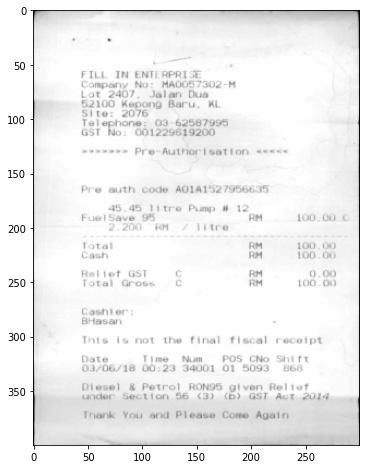

Labels: FILL IN ENTERPRISE [NL] LOT 2407, JALAN DUA 52100 KEPONG BARU, KL
Pred: STAMFORD BRADLEY SDN BHD [NL] LOT P.R. JALAN KAKA, 51300 KUALA JAYA,



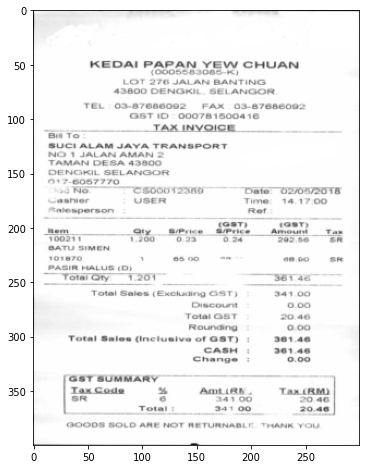

Labels: KEDAI PAPAN YEW CHUAN [NL] LOT 276 JALAN BANTING 43800 DENGKIL, SELANGOR
Pred: KEDAI PAPAN YES CHAMK [NL] LOT 236 JALAN TAMAN 41800 DUKU KANG, SELANGOR.



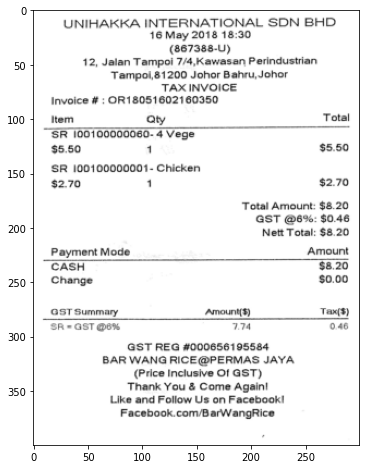

Labels: UNIHAKKA INTERNATIONAL SDN BHD [NL] 12, JALAN TAMPOI 7/4,KAWASAN PERINDUSTRIAN TAMPOI,81200 JOHOR BAHRU,JOHOR
Pred: UNIHAKKA INTERNATIONAL SDN BHD [NL] 12, JALAN TAMPOI 7/4,KAWASAN PERINDUSTRIAN TAMPOI,81200 JOHOR BAHRU,JOHOR



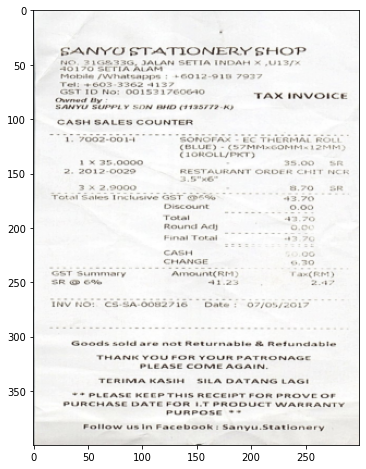

Labels: SANYU STATIONERY SHOP [NL] NO. 31G&33G, JALAN SETIA INDAH X ,U13/X 40170 SETIA ALAM
Pred: APPLIED (M) SDN BHD [NL] NO. 2, JALAN MEETI JAYA, 97400 KUALA LUMPUR.



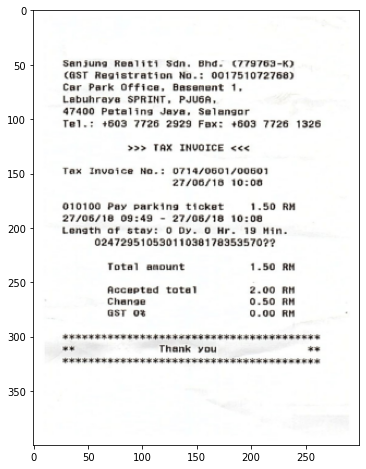

Labels: SANJUNG REALITI SDN. BHD. [NL] CAR PARK OFFICE, BASEMENT 1, LABUHRAYA SPRINT, PJU6A, 47400 PETALING JAYA, SELANGOR
Pred: STOCK HAS FILTER SDN BHD [NL] LOT EXL (KL), JALAN BRAND SINCH J, 40100 PUS SELANGOR



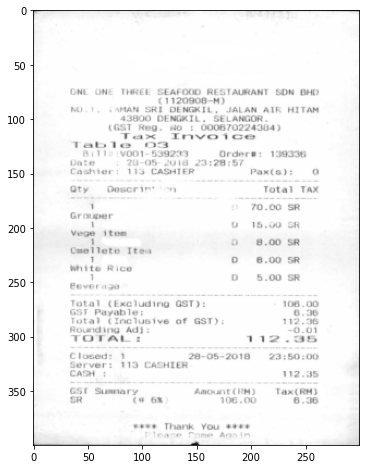

Labels: ONE ONE THREE SEAFOOD RESTAURANT SDN BHD [NL] NO. 1, TAMAN SRI DENGKIL, JALAN AIR HITAM 43800 DENGKIL, SELANGOR.
Pred: SAN HONG KONG DIVISION SDN BHD [NL] NO.1, JALAN KICKEN, 47300 JALAN KENTUCKY



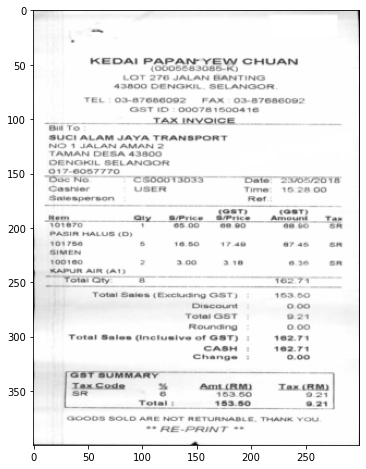

Labels: KEDAI PAPAN YEW CHUAN [NL] LOT 276 JALAN BANTING 43800 DENGKIL, SELANGOR.
Pred: KEDAI PAPAN YES CMEAN [NL] LOT 236 JALAN PERANCANC 63800 DRUGKK, SELANGOR.



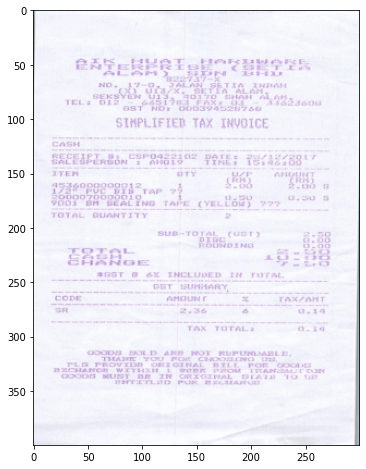

Labels: AIK HUAT HARDWARE ENTERPRISE (SETIA ALAM) SDN BHD [NL] NO. 17-G, JALAN SETIA INDAH (X) U13/X, SETIA ALAM, SEKSYEN U13, 40170 SHAH ALAM,
Pred: JIM TRAVEL TRAVEL SDN BHD [NL] NO. 15-JL-LN-80 8374, DENNIS SELANGOR DANA, SELANGOR



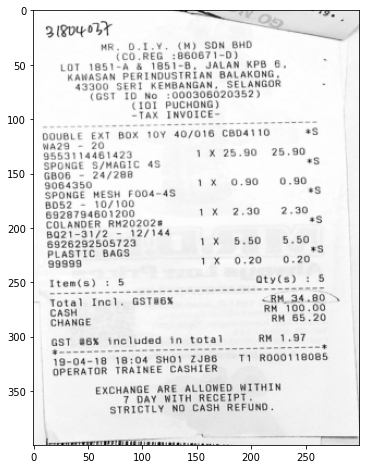

Labels: MR. D.I.Y. (M) SDN BHD [NL] LOT 1851-A & 1851-B, JALAN KPB 6, KAWASAN PERINDUSTRIAN BALAKONG, 43300 SERI KEMBANGAN, SELANGOR
Pred: HEALTH J. (M) SDN BHD [NL] LOT 1851-A & 1851-B, JALAN KPB 6, KAWASAN PERINDUSTRIAN BALAKONG, 43300 SERI KEMBANGAN.



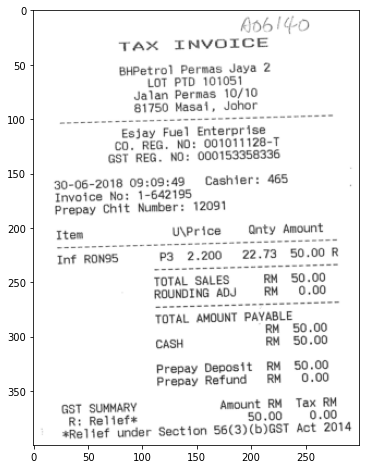

Labels: ESJAY FUEL ENTERPRISE [NL] LOT PTD 101051 JALAN PERMAS 10/10 81750 MASAI, JOHOR
Pred: REGROUND FINANG SDN BHD [NL] LOT P29 12/25 JALAN BURNAR 14776 BLYNN KAWA LUMPUR



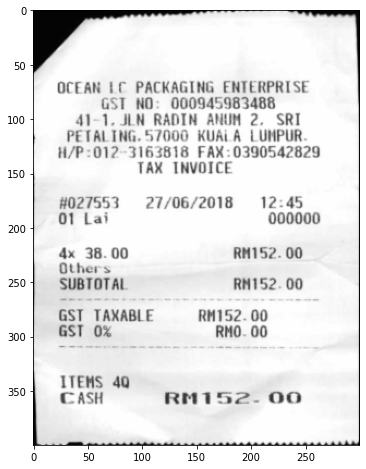

Labels: OCEAN LC PACKAGING ENTERPRISE [NL] 41-1, JLN RADIN ANUM 2, SRI PETALING, 57000 KUALA LUMPUR.
Pred: GEORGE HEALTH AND BEAUTY SDN BHD [NL] LOT 25, JALAN JAWA, 61200 SERI KUALA LUMPUR



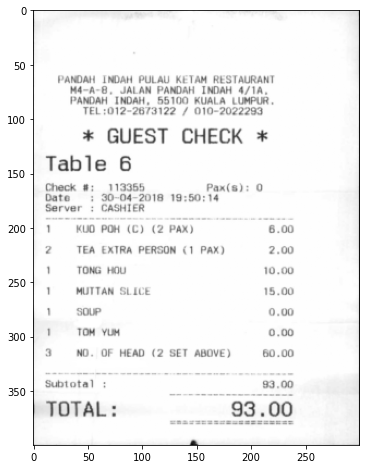

Labels: PANDAH INDAH PULAU KETAM RESTAURANT [NL] M4-A-8, JALAN PANDAH INDAH 4/1A, PANDAH INDAH, 55100 KUALA LUMPUR.
Pred: KING SIZE BRIEFING SDN BHD [NL] NO.8, JALAN HANHAN, YAYA, JALAN JENK



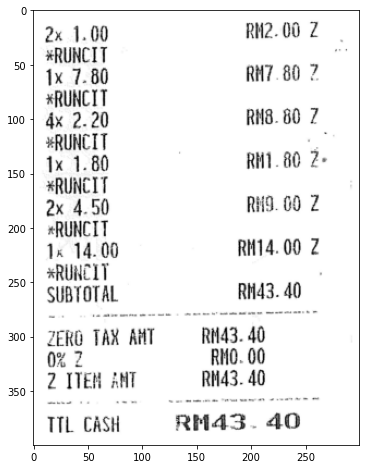

Labels: KEDAI RUNCIT ZBH [NL] NO.17,JALAN PERMAS 1/7, BANDAR BARU PERMAS JAYA,81750,MASAI
Pred: MARKET SDN BHD [NL] LOT, JALAN PERANC CENTER



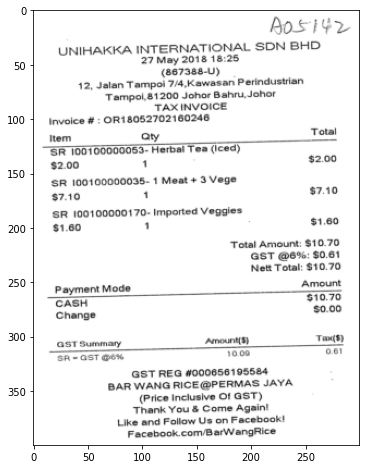

Labels: UNIHAKKA INTERNATIONAL SDN BHD [NL] 12, JALAN TAMPOI 7/4,KAWASAN PERINDUSTRIAN TAMPOI,81200 JOHOR BAHRU,JOHOR
Pred: UNIHAKKA INTERNATIONAL SDN BHD [NL] 12, JALAN TAMPOI 7/4,KAWASAN PERINDUSTRIAN TAMPOI,81200 JOHOR BAHRU,JOHOR



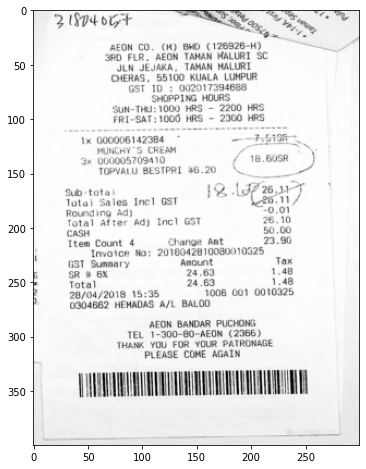

Labels: AEON CO. (M) BHD [NL] 3RD FLR, AEON TAMAN MALURI SC JLN JEJAKA, TAMAN MALURI CHERAS, 55100 KUALA LUMPUR
Pred: AEON CO. (M) BHD [NL] 3RD FLR, AEON TAMAN MALURI SC JLN JEJAKA, TAMAN MALURI CHERAS, 55100 KUALA LUMPUR



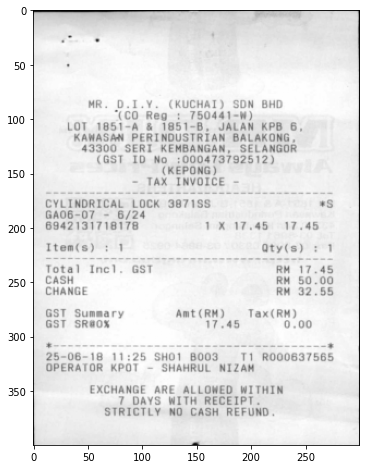

Labels: MR. D.I.Y. (KUCHAI) SDN BHD [NL] LOT 1851-A & 1851-B, JALAN KPB 6, KAWASAN PERINDUSTRIAN BALAKONG, KAWASAN PERINDUSTRIAN BALAKONG, 43300 SERI KEMBANGAN, SELANGOR
Pred: MR. D.I.Y. (KUCHAI) SDN BHD [NL] LOT 1851-A & 1851-B, JALAN KPB 6, KAWASAN PERINDUSTRIAN BALAKONG, 43300 SERI KEMBANG



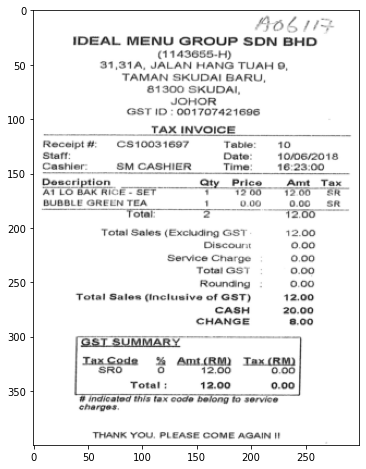

Labels: IDEAL MENU GROUP SDN BHD [NL] 31,31A, JALAN HANG TUAH 9, TAMAN SKUDAI BARU, 81300 SKUDAI, JOHOR
Pred: FEDA HARVARD BENTUCKY SDN BHD [NL] S/T5A, JALAN MARINE TRIANG TEAMS TEAMS TEAMS TEAMS TEAMS TEAMS TEAMS TEAMS TEAMS TE



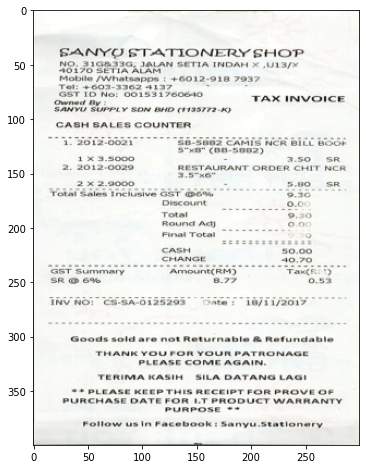

Labels: SANYU STATIONERY SHOP [NL] NO. 31G&33G, JALAN SETIA INDAH X ,U13/X 40170 SETIA ALAM
Pred: BANNON FIR ENTRY SDN BHD [NL] NO. 10) JALAN BURNING, JAYA, 97550 KUALA LUMPUR



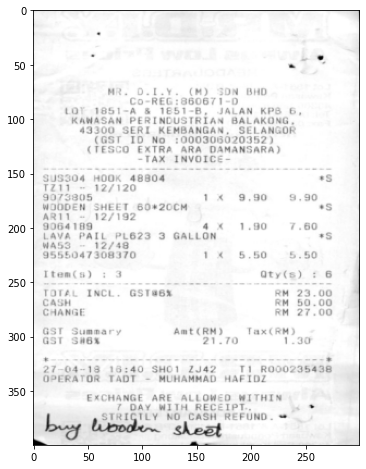

Labels: MR. D.I.Y. (M) SDN BHD [NL] LOT 1851-A & 1851-B, JALAN KPB 6, KAWASAN PERINDUSTRIAN BALAKONG, 43300 SERI KEMBANGAN, SELANGOR
Pred: MR. D.I.Y. (M) SDN BHD [NL] LOT 1851-A & 1851-B, JALAN KPB 6, KAWASAN PERINDUSTRIAN BALAKONG, 43300 SERI KEMBANGAN,



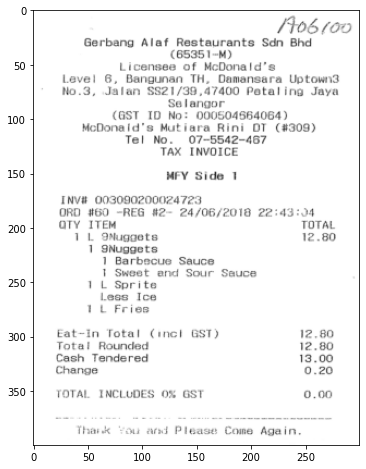

Labels: GERBANG ALAF RESTAURANTS SDN BHD [NL] LEVEL 6, BANGUNAN TH, DAMANSARA UPTOWN3 NO.3, JALAN SS21/39, 47400 PETALING JAYA SELANGOR
Pred: BRENNAN ALAF RESTAURANT SDN BHD [NL] LEVEL 6, BANQUEAN 7/8, JALAN SS13, 47400 PERLING JAYA, SELANGOR



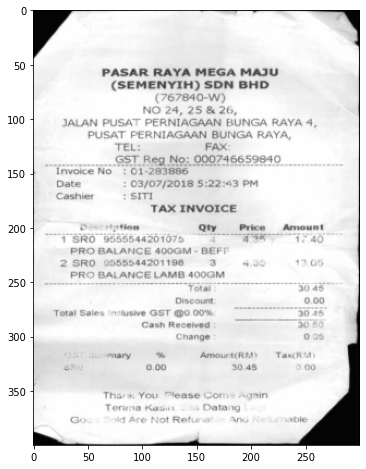

Labels: PASAR RAYA MEGA MAJU (SEMENYIH) SDN BHD [NL] NO 24, 25 & 26, JALAN PUSAT PERNIAGAAN BUNGA RAYA 4, PUSAT PERNIAGAAN BUNGA RAYA,
Pred: EYE PAINAN HAMISHING [NL] 149, JALAN JEFFREY JEJEKAN HAYA 6, JAYA, 47300 KUALA LUMPUR.



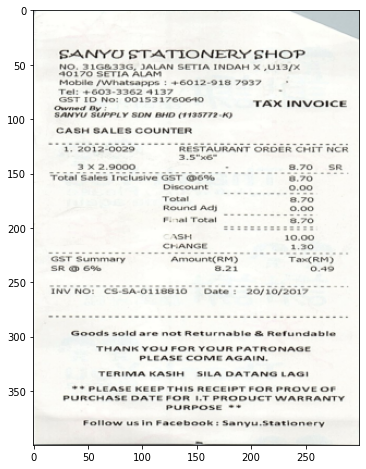

Labels: SANYU STATIONERY SHOP [NL] NO. 31G&33G, JALAN SETIA INDAH X ,U13/X 40170 SETIA ALAM
Pred: SAMPLE CRAFT SDN BHD [NL] NO. 193, JALAN BETMAN 1/1/81, 90100 SHAH SELANGOR



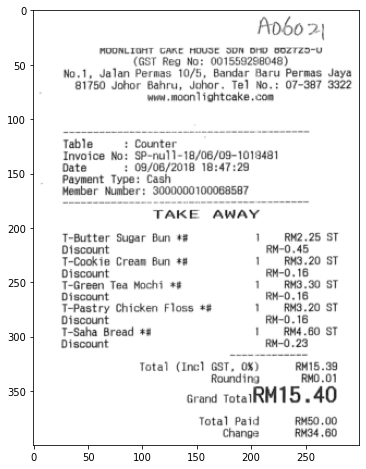

Labels: MOONLIGHT CAKE HOUSE SDN BHD [NL] NO.1, JALAN PERMAS 10/5, BANDAR BARU PERMAS JAYA 81750 JOHOR BAHRU, JOHOR.
Pred: PROGRAM CASH GROUND BHD [NL] AL LC, JALAN BURN, TAMAN BARRU BURN, 40300 KUALA LUMPUR



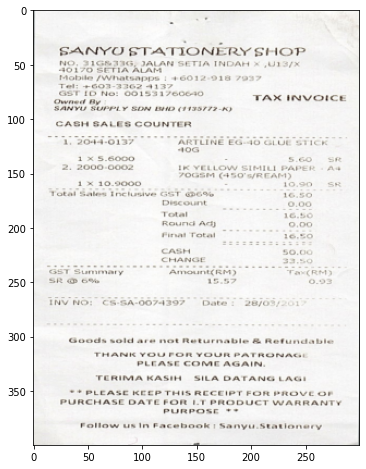

Labels: SANYU STATIONERY SHOP [NL] NO. 31G&33G, JALAN SETIA INDAH X ,U13/X 40170 SETIA ALAM
Pred: APPA CARRY SDN BHD [NL] NO 3, JALAN HISPAN SUSAN RI JAYA, 87500 KUALA LUMPUR



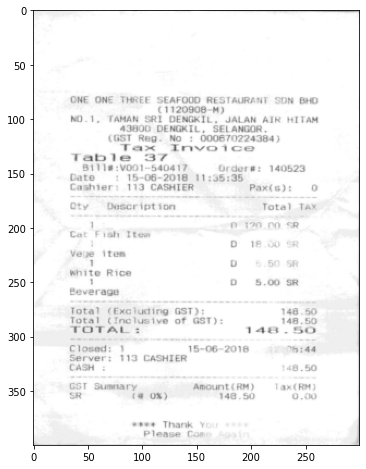

Labels: ONE ONE THREE SEAFOOD RESTAURANT SDN BHD [NL] NO.1, TAMAN SRI DENGKIL, JALAN AIR HITAM 43800 DENGKIL, SELANGOR.
Pred: JEWSELNEY BRIEFORD SDN BHD [NL] NO. 17, JALAN JENHESS, JALAN JAYA, 43300 SELANGOR



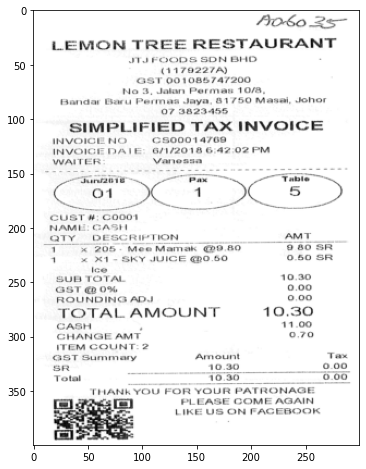

Labels: LEMON TREE RESTAURANT JTJ FOODS SDN BHD [NL] NO 3, JALAN PERMAS 10/8, BANDAR BARU PERMAS JAYA, 81750 MASAI, JOHOR
Pred: FEDERAL EXPRESS SACRAMENTO (NL) 57-TAMAN DAMANS TAMAN, 55100 KLANG,



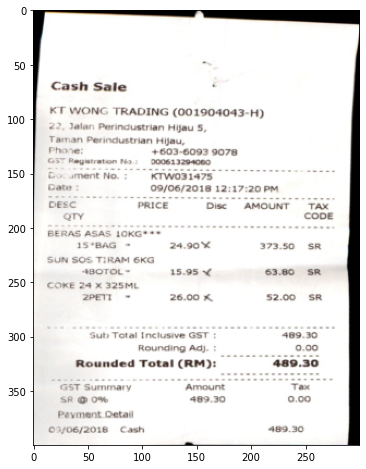

Labels: KT WONG TRADING [NL] 22, JALAN PERINDUSTRIAN HIJAU 5, TAMAN PERINDUSTRIAN HIJAU,
Pred: CRAFT CRAFT S/B [NL] NO.15, JALAN PERGUSONS JALAN PERGUSONS JALAN PERGUSONS JALAN PERGUSONS JALAN PERGUSONS JALAN PERGUSON



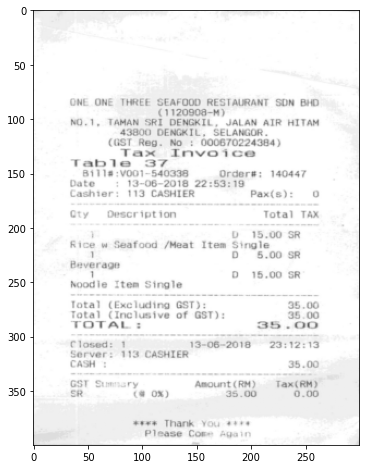

Labels: ONE ONE THREE SEAFOOD RESTAURANT SDN BHD [NL] NO.1, TAMAN SRI DENGKIL, JALAN AIR HITAM 43800 DENGKIL, SELANGOR.
Pred: DR.SELANGOR PERMANENTS SDN BHD [NL] NO.2, JALAN BREYNANG 23, JALAN 87100 CEUR, SELANGOR



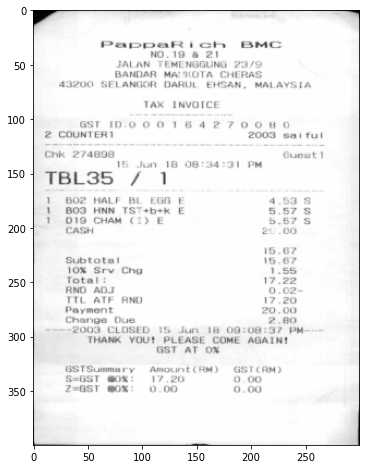

Labels: PAPPARICH BMC [NL] NO.19 & 21 JALAN TEMENGGUNG 23/9 BANDAR MAHKOTA CHERAS 43200 SELANGOR DARUL EHSAN, MALAYSIA
Pred: SANFRANO [NL] JALAN TELENGONG 3/10 BANDAR MAH OFFICE CHANGE SELANGOR DAHEL SELANGOR



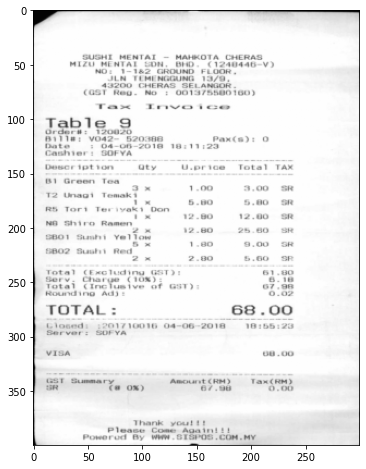

Labels: MIZU MENTAI SDN. BHD. [NL] NO: 1-1&2 GROUND FLOOR, JLN TEMENGGUNG 13/9, 43200 CHERAS SELANGOR.
Pred: INDY MUFLS SDN. BHD. [NL] NO.1, JALAN GORDAN FLAG, JOLIN TENENGDAG 13/49, 43200 CHERAK SELANGOR



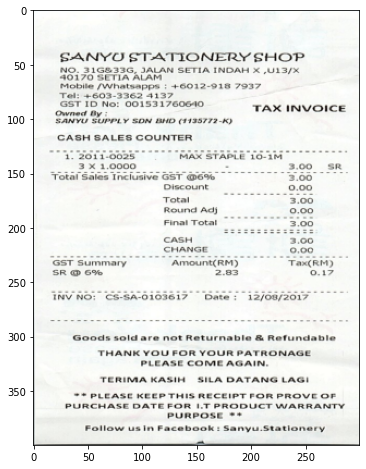

Labels: SANYU STATIONERY SHOP [NL] NO. 31G&33G, JALAN SETIA INDAH X ,U13/X 40170 SETIA ALAM
Pred: SAMPLEY TAMAN EXPORT SDN BHD [NL] NO. 3 JALAN BETTAMAN SLIKA KAWA 81500 KUALA LUMPUR.



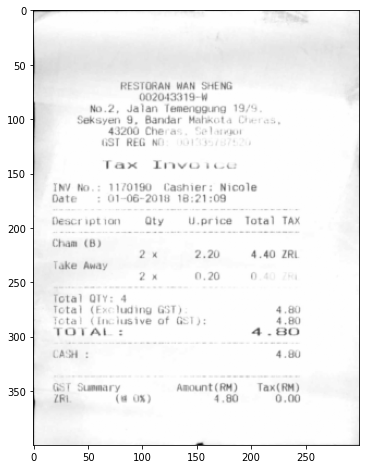

Labels: RESTORAN WAN SHENG [NL] NO.2, JALAN TEMENGGUNG 19/9, SEKSYEN 9, BANDAR MAHKOTA CHERAS, 43200 CHERAS, SELANGOR
Pred: RESTORAN WAN SHENG [NL] NO.2, JALAN TEMENGGUNG 19/9, SEKSYEN 9, BANDAR MAHWHIT, 43200 CHERAS, SELANGOR



In [36]:
batch = next(iter(test_dl))
batch[0] = batch[0].cuda()

test_model.eval()

with torch.no_grad():
    pred_tokens = test_model(batch)

decoded_preds = [test_model.tokenizer.decode(t) for t in pred_tokens]

images, labels, tokens = batch

for image, label, pred in zip(images, labels, decoded_preds):
    plt.figure(figsize=(6, 8))
    plt.imshow(((image.squeeze(0).cpu().numpy().transpose(1, 2, 0)/2+1)))
    plt.show()
    print(f'Labels: {label}\nPred: {pred}\n')

## Observações

**1. Essa abordagem foi idealizada de forma a otimizar a conexão entre a efficient-net e o T5 e esperavasse ser bastante promissora. No entanto, a performance de 48.25% não se mostrou tão eficiente atingido uma abordagem maior que a abordagem 1 (45.88%) e 3 (35.82%) e menor que a abordagem 2 (58.77%).**
